In [1]:
import os
os.chdir("/workspace")


import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import confseq
from confseq import predmix, conjmix_bounded, betting
import algorithm
from algorithm import ConfSeq, Hypothesis


In [3]:
class HoffConf(algorithm.ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = predmix.predmix_hoeffding_cs(x, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs
    
    @staticmethod
    def standardise(x):
        return (x - x.min()) / (x.max() - x.min())
    

class EmpbernConf(algorithm.ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)

        lower_cs, higher_cs = predmix.predmix_empbern_twosided_cs(x, self.conf_lvl, running_intersection=False)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs
    

class EmpbernConjmix(algorithm.ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = conjmix_bounded.conjmix_empbern_twosided_cs(x, 1/12, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs

class EmpbernBetting(algorithm.ConfSeq):
    def __init__(self, conf_lvl: float, min_val=None, max_val=None):
        super().__init__(conf_lvl, min_val, max_val)
    
    def calculate_cs(self, x):
        # min_val, max_val =  x.min(), x.max()
        # normalized = (x - min_val) / (max_val - min_val)
        lower_cs, higher_cs = betting.betting_cs(x, self.conf_lvl)

        # lower_cs = lower_cs * (max_val - min_val) + min_val
        # higher_cs = higher_cs * (max_val - min_val) + min_val
        return lower_cs, higher_cs

In [4]:
class H0(Hypothesis):
    def __init__(self, tolerance:float, lower_bound:ConfSeq, upper_bound:ConfSeq):
        super().__init__(tolerance, lower_bound, upper_bound)
    
    @property
    def source_upper(self):
        return self.source_upper_cs[-1] + self.tolerance
    
    @property
    def target_lower(self):
        return self.target_lower_cs


        

In [5]:
def print_stats(data):
    print(f"data statistics: mean={np.mean(data)}, std={np.std(data)}")
    print(f"min={np.min(data)}, median={np.median(data)}, max={np.max(data)}")


np.random.seed(0)
N = 100000
data = np.random.normal(2, 3, N)
# data = np.random.uniform(0.4, 0.5, N)
# data = np.random.

print_stats(data)


data statistics: mean=2.004730101524376, std=2.992019063482145
min=-12.556352959540352, median=2.005160666256744, max=14.725315738711089


In [6]:
source_bound = HoffConf(0.01)
target_bound = EmpbernConf(0.01)

source_data = np.random.normal(1.1, 3, 2000)
print_stats(source_data)

hyp = H0(tolerance=0.1, lower_bound=source_bound, upper_bound=target_bound)
hyp.calc_source_upper_cs(source_data)
hyp.test(data)

data statistics: mean=1.1384736776358135, std=2.9589730222630215
min=-7.6084721053825835, median=1.0717820757847494, max=11.565477698443443


False

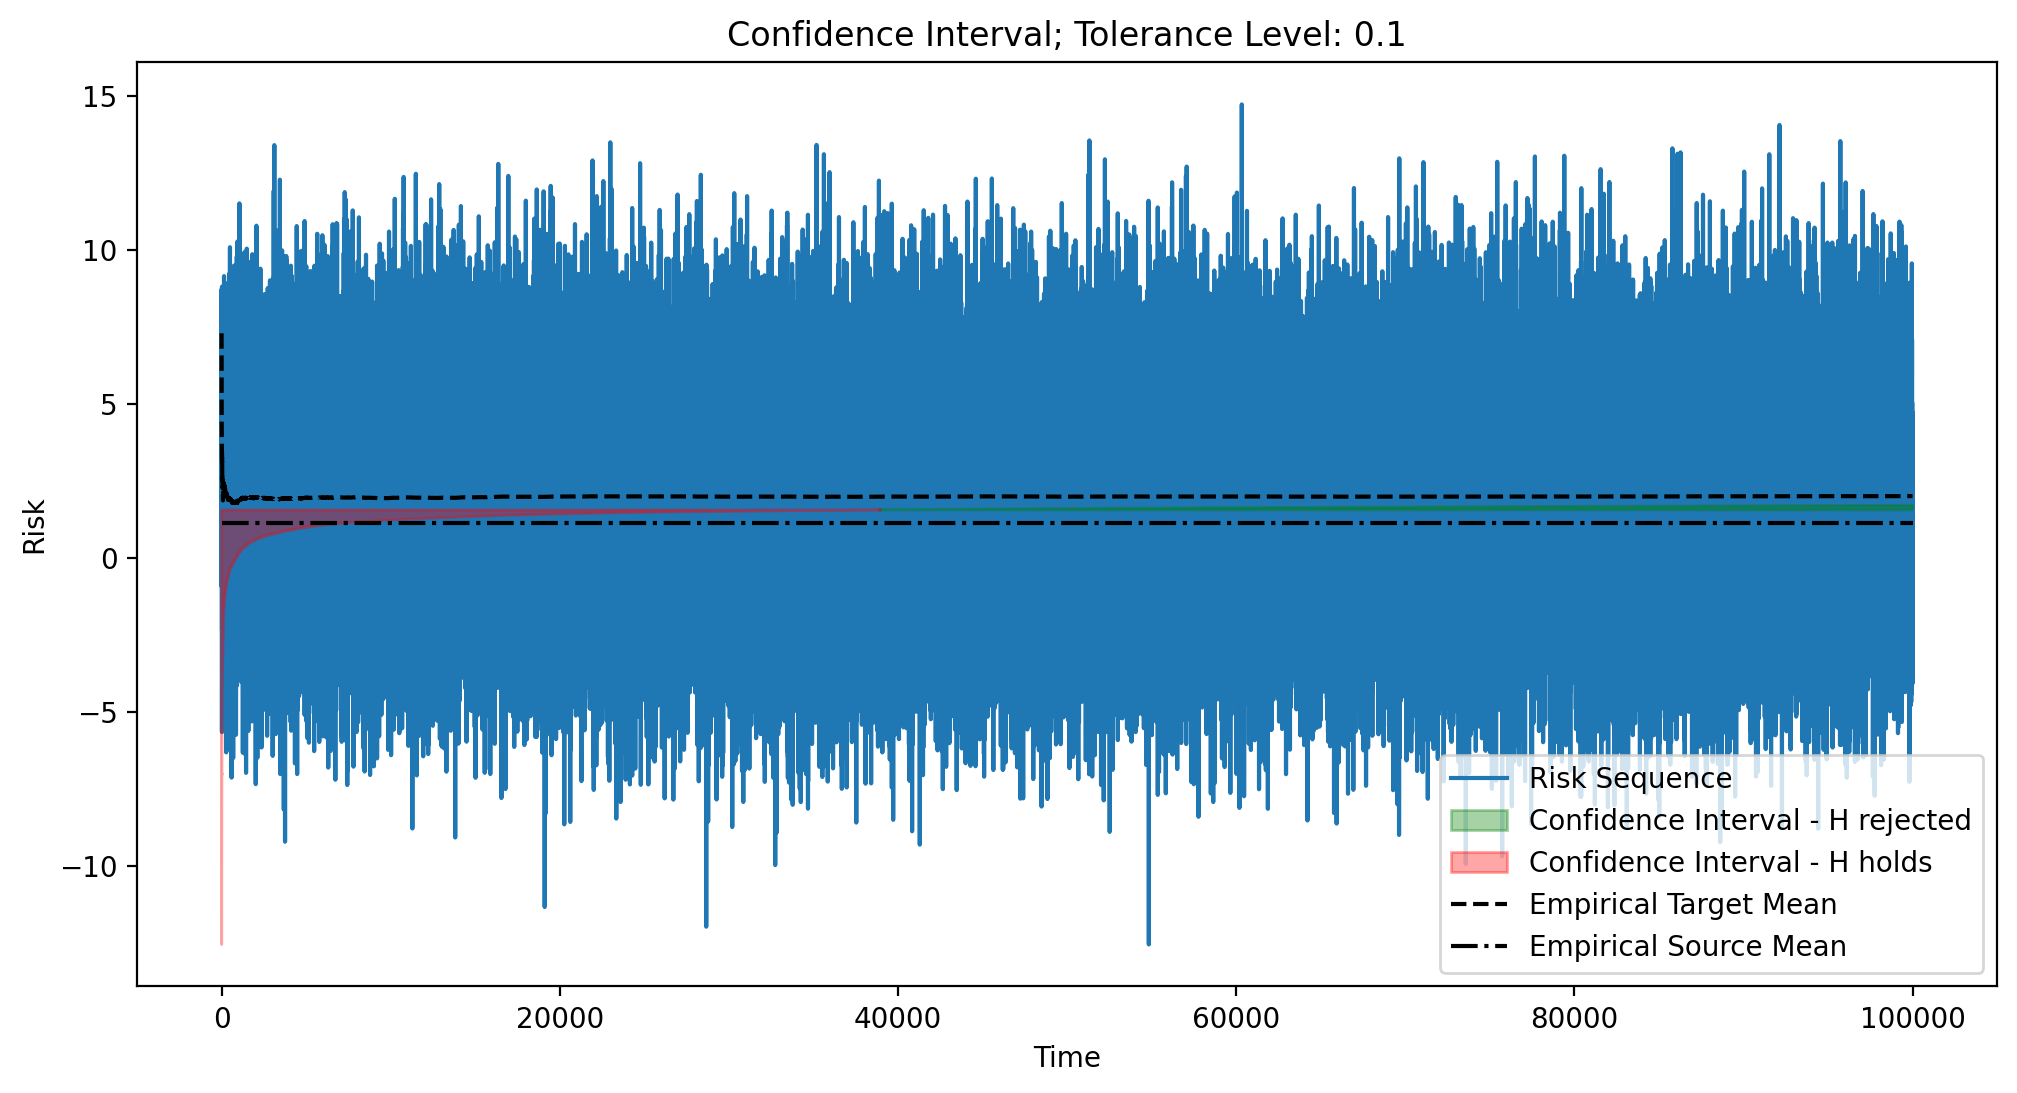

In [7]:
hyp.plot()

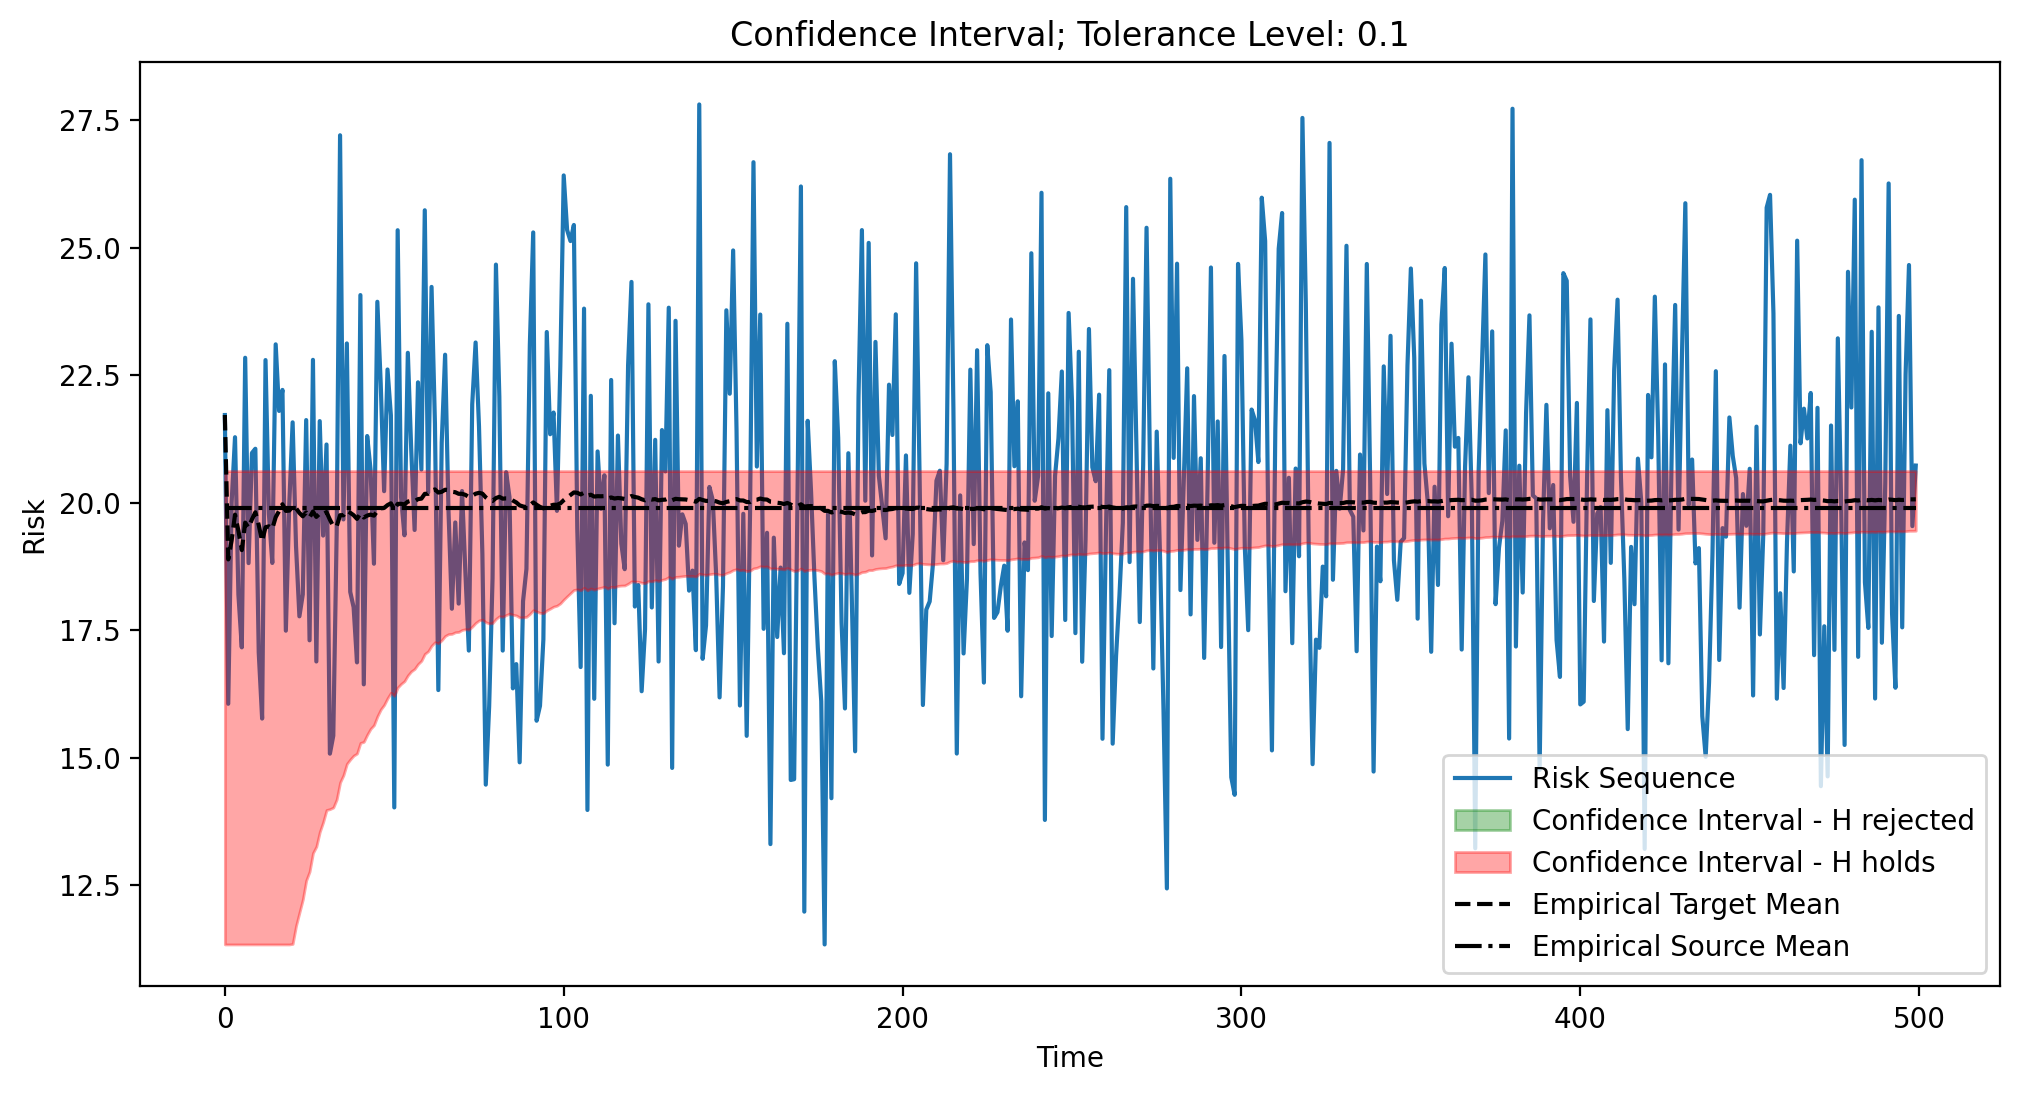

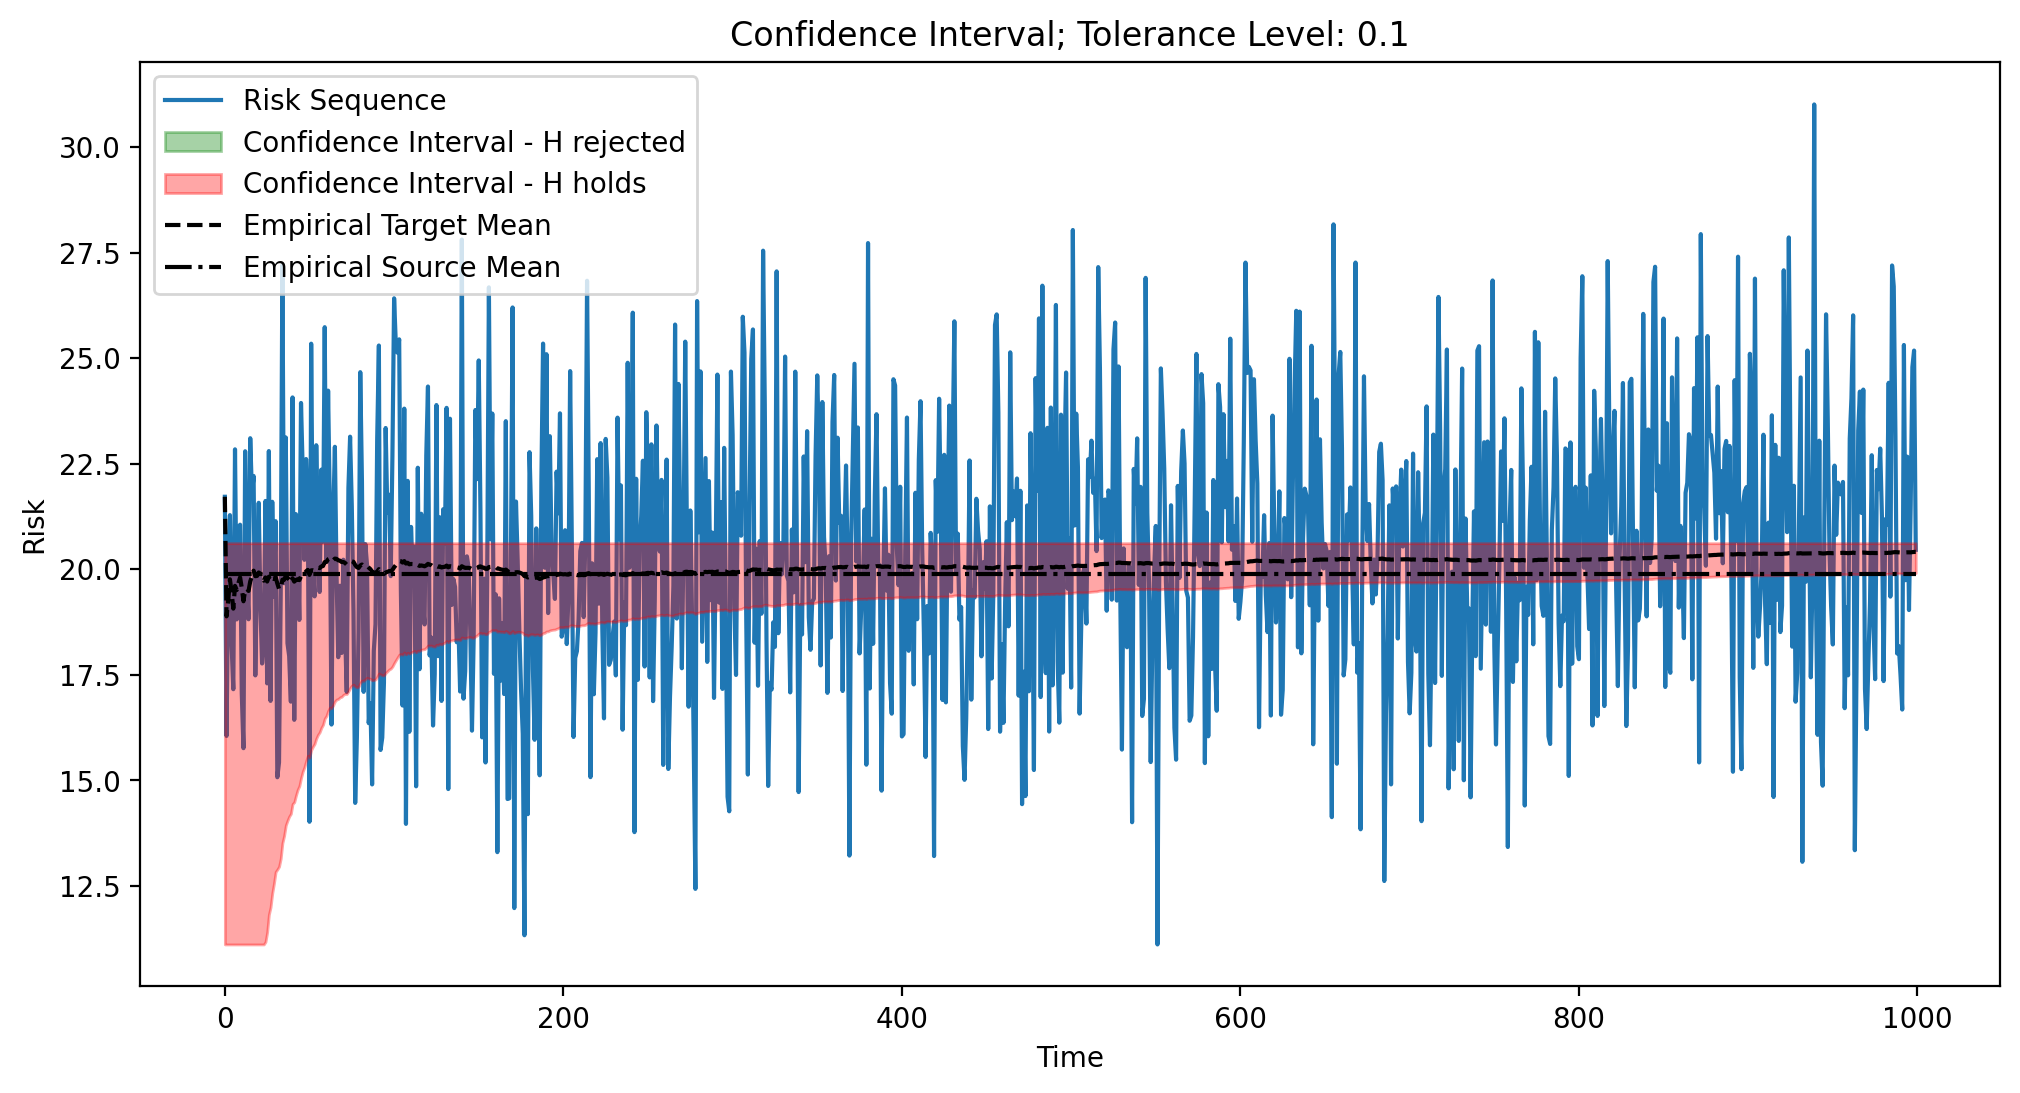

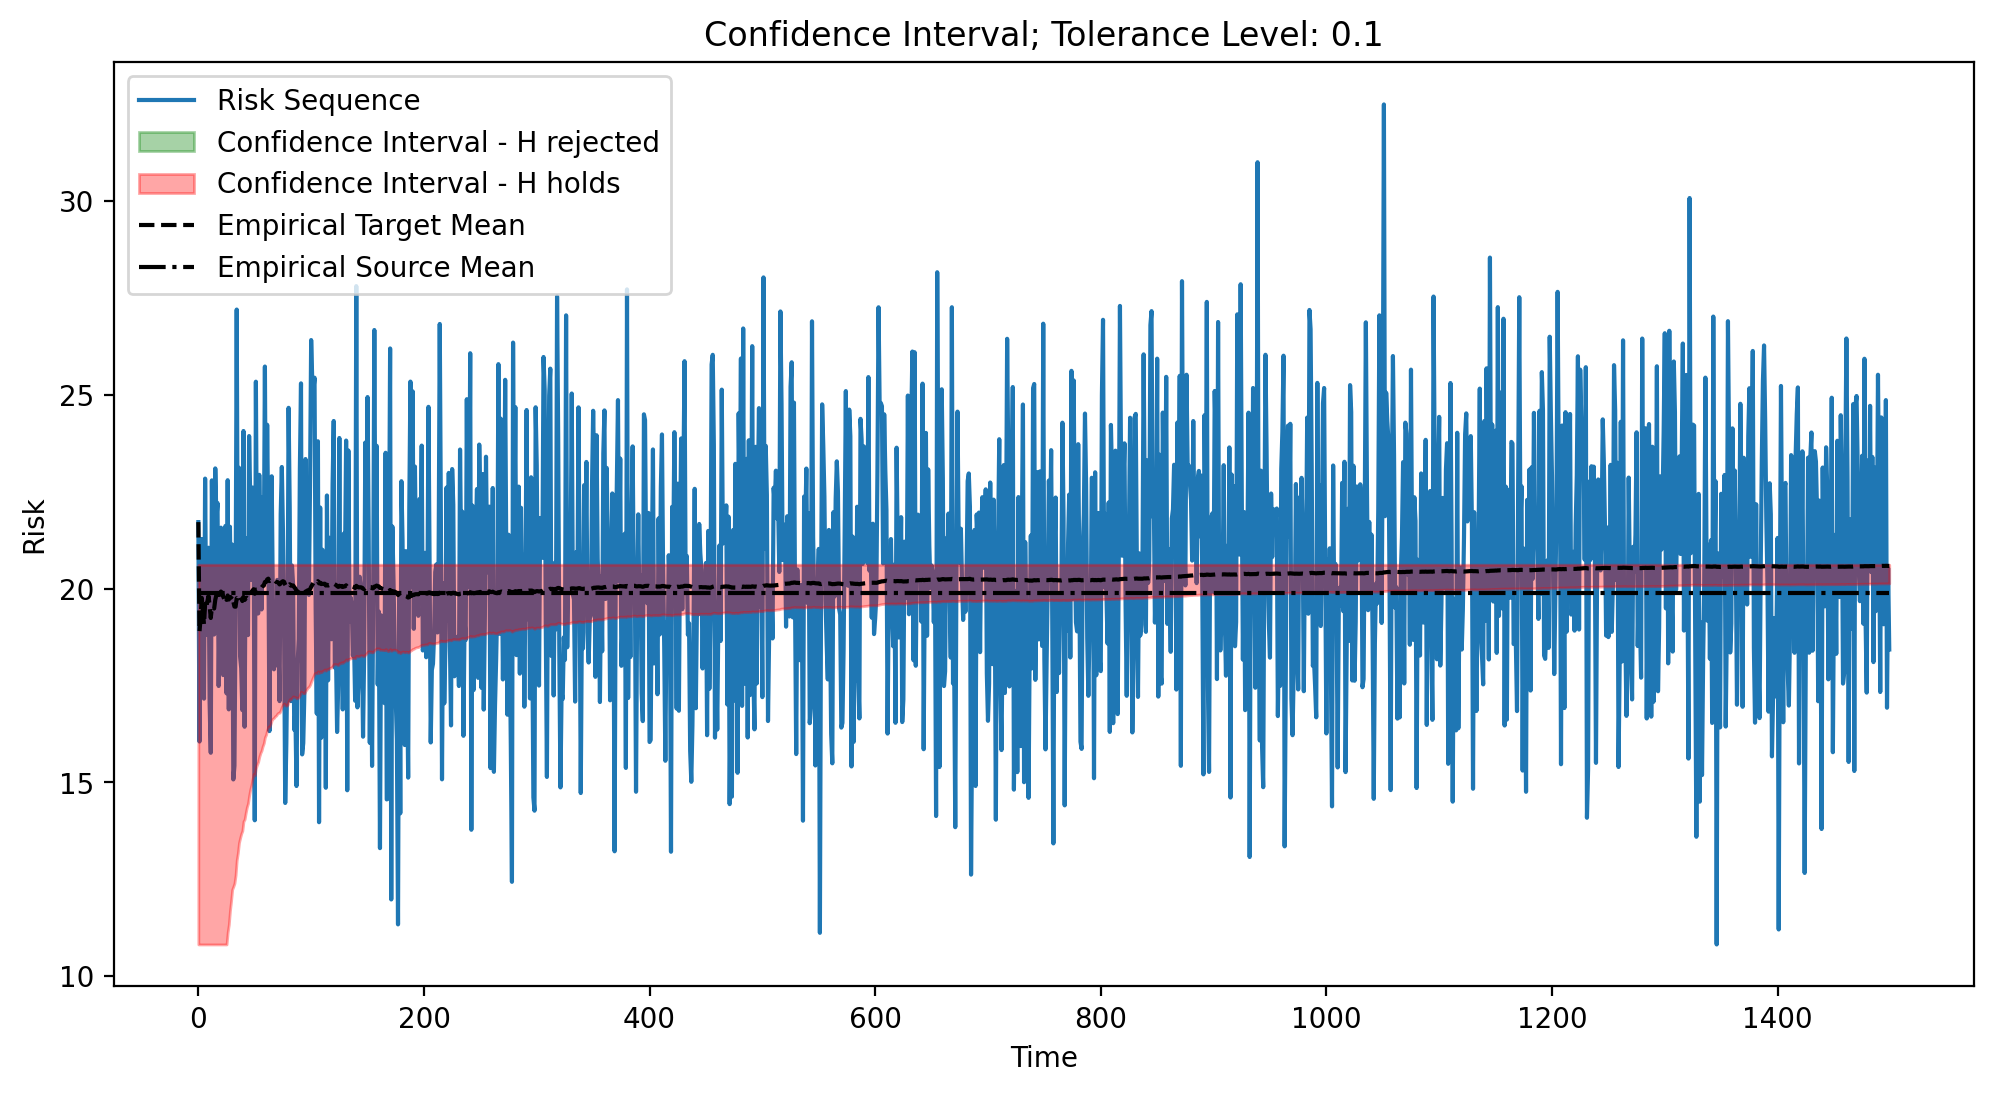

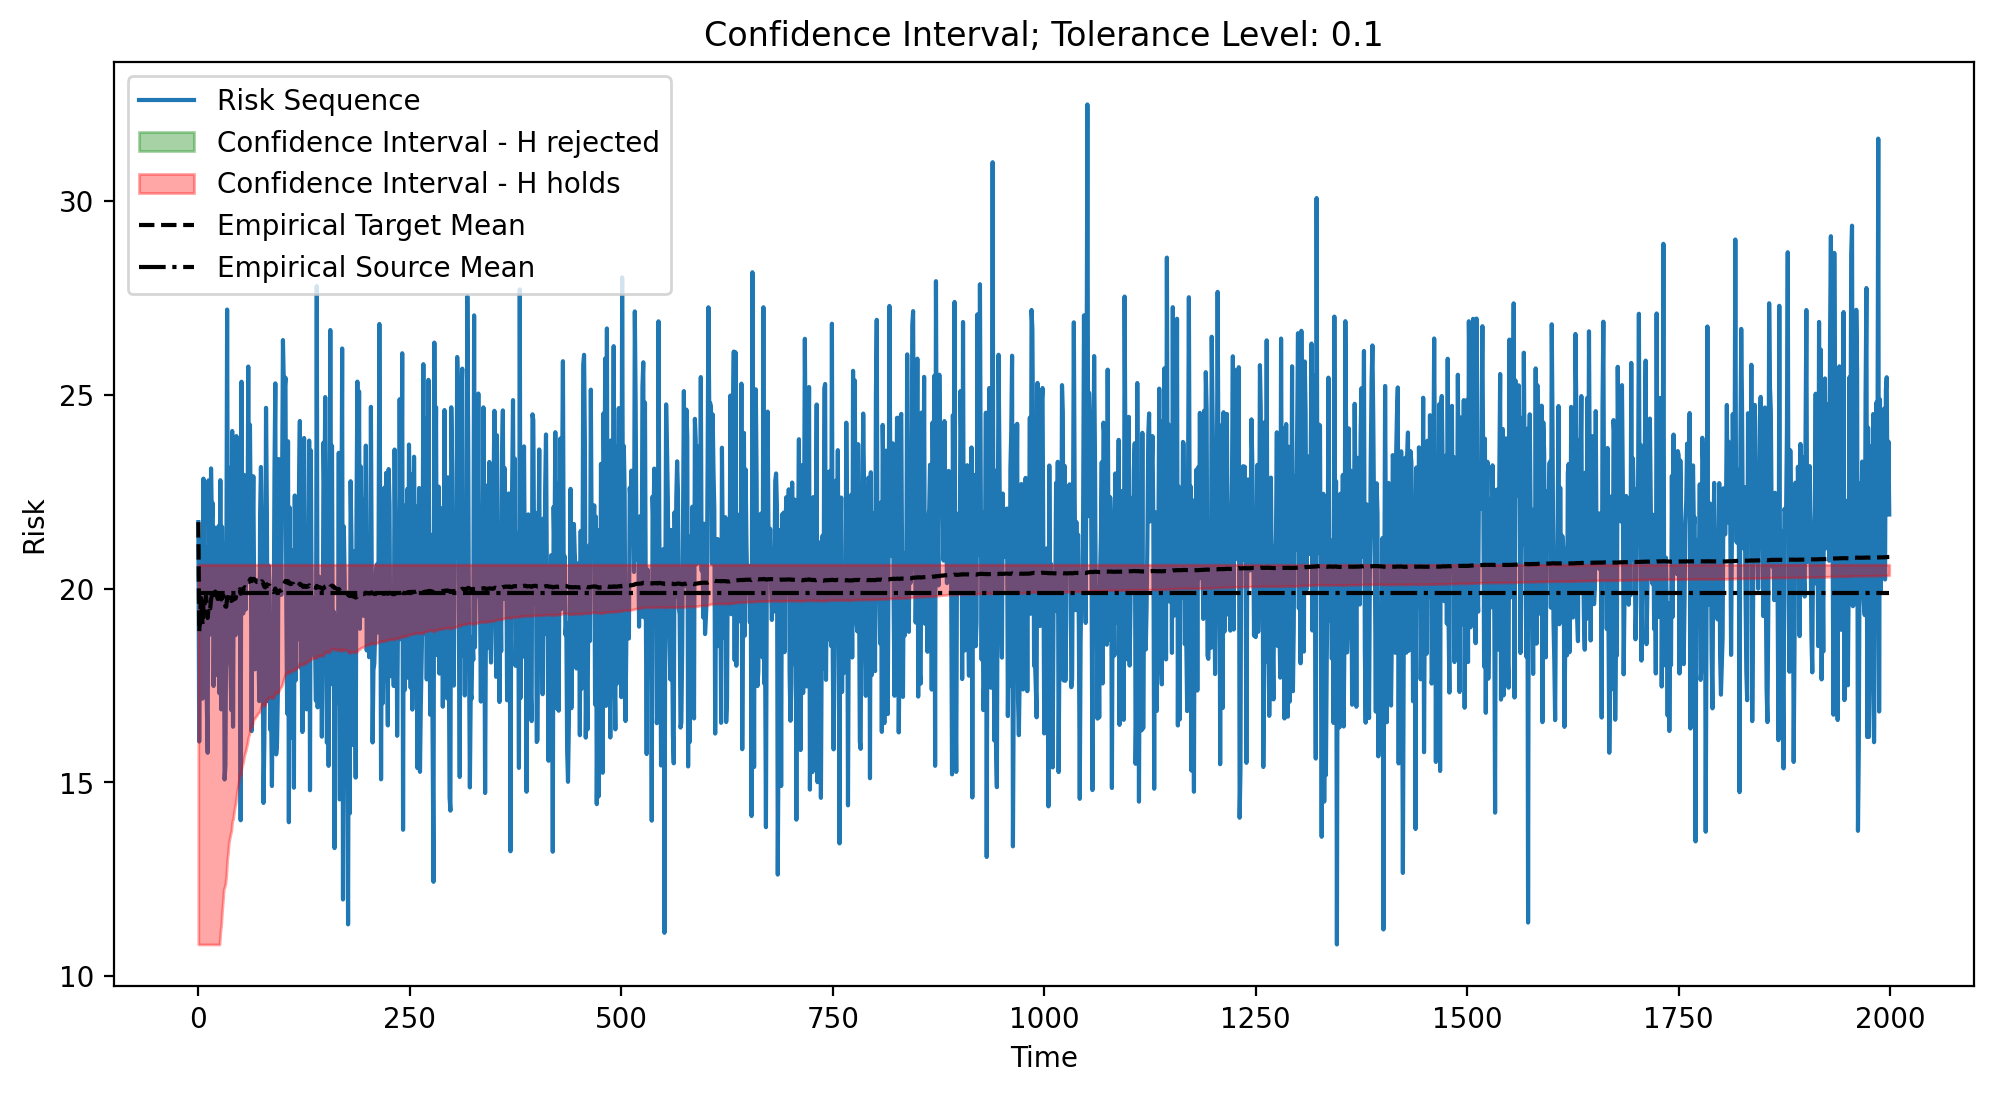

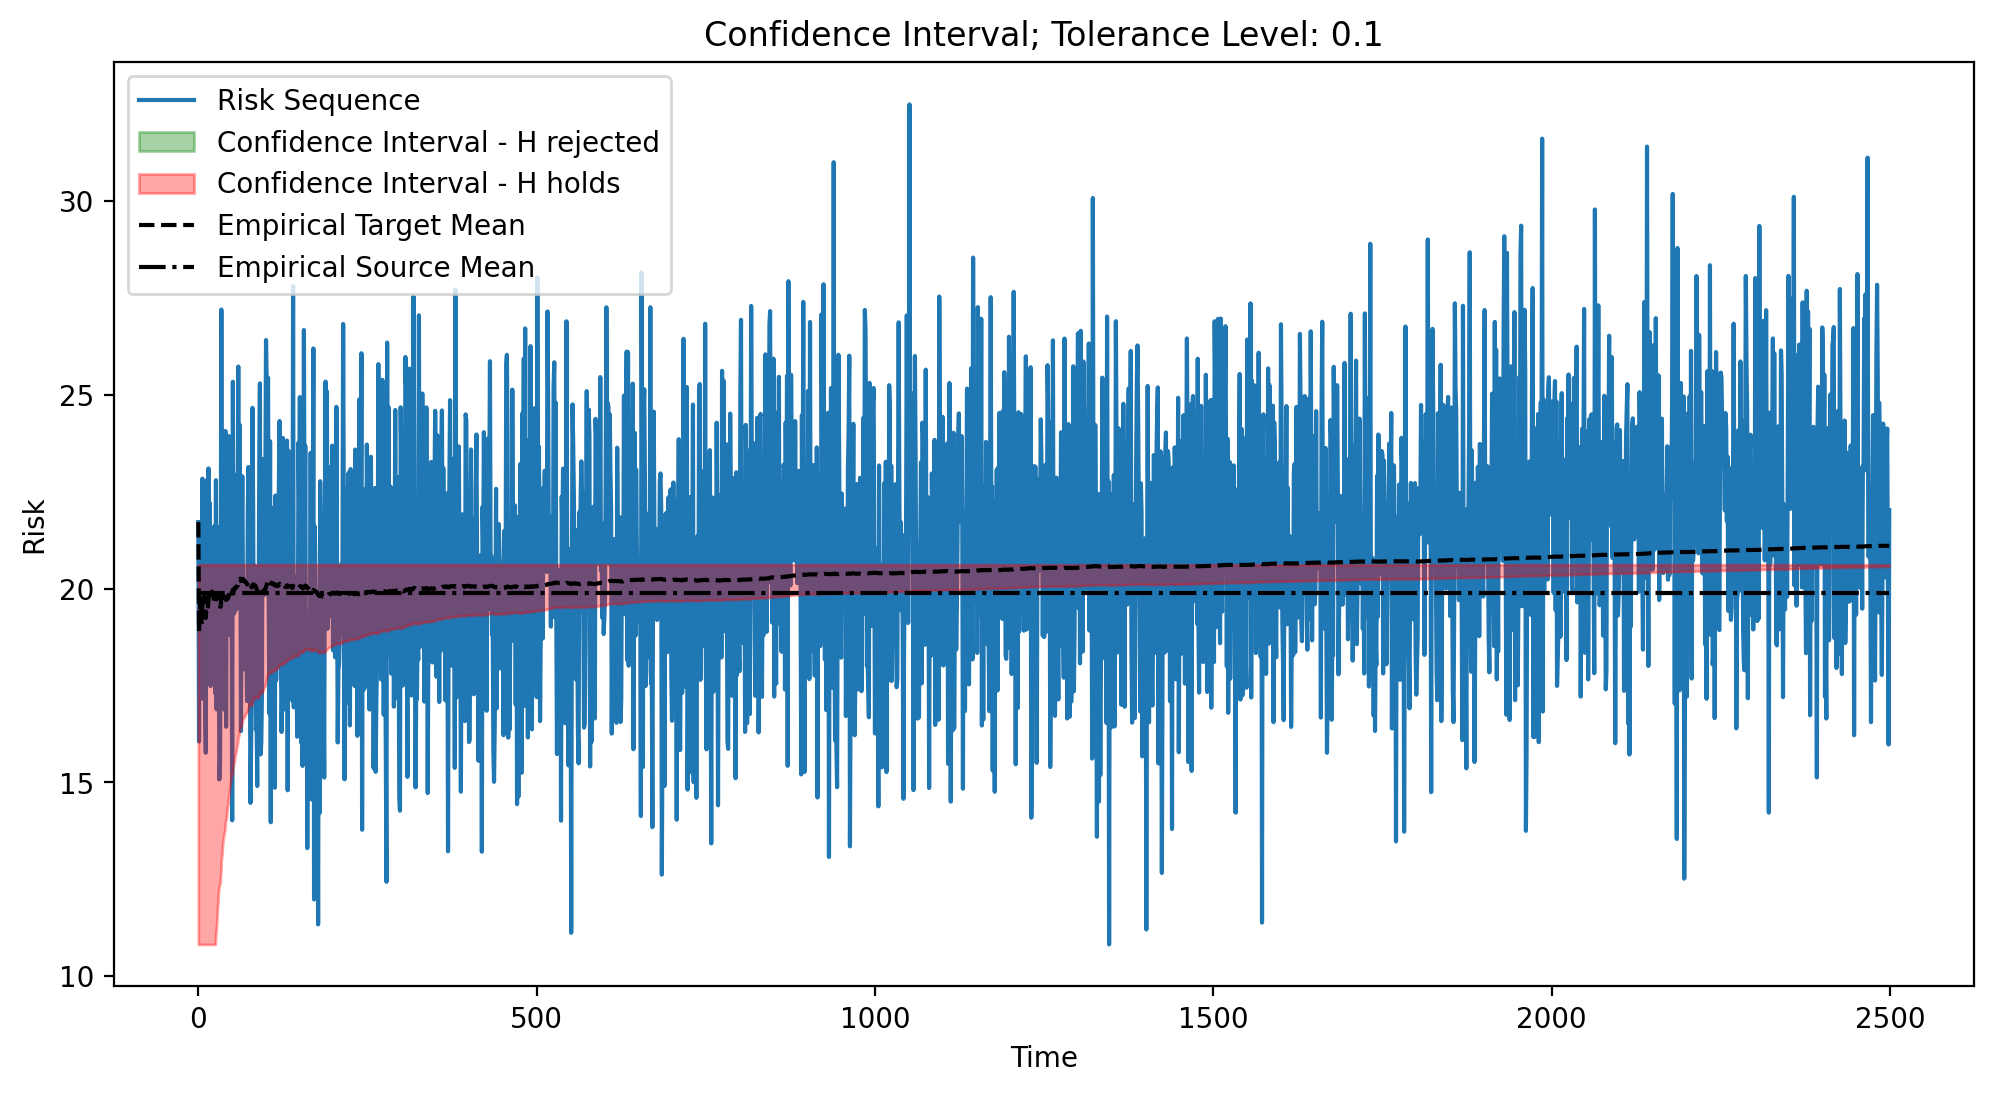

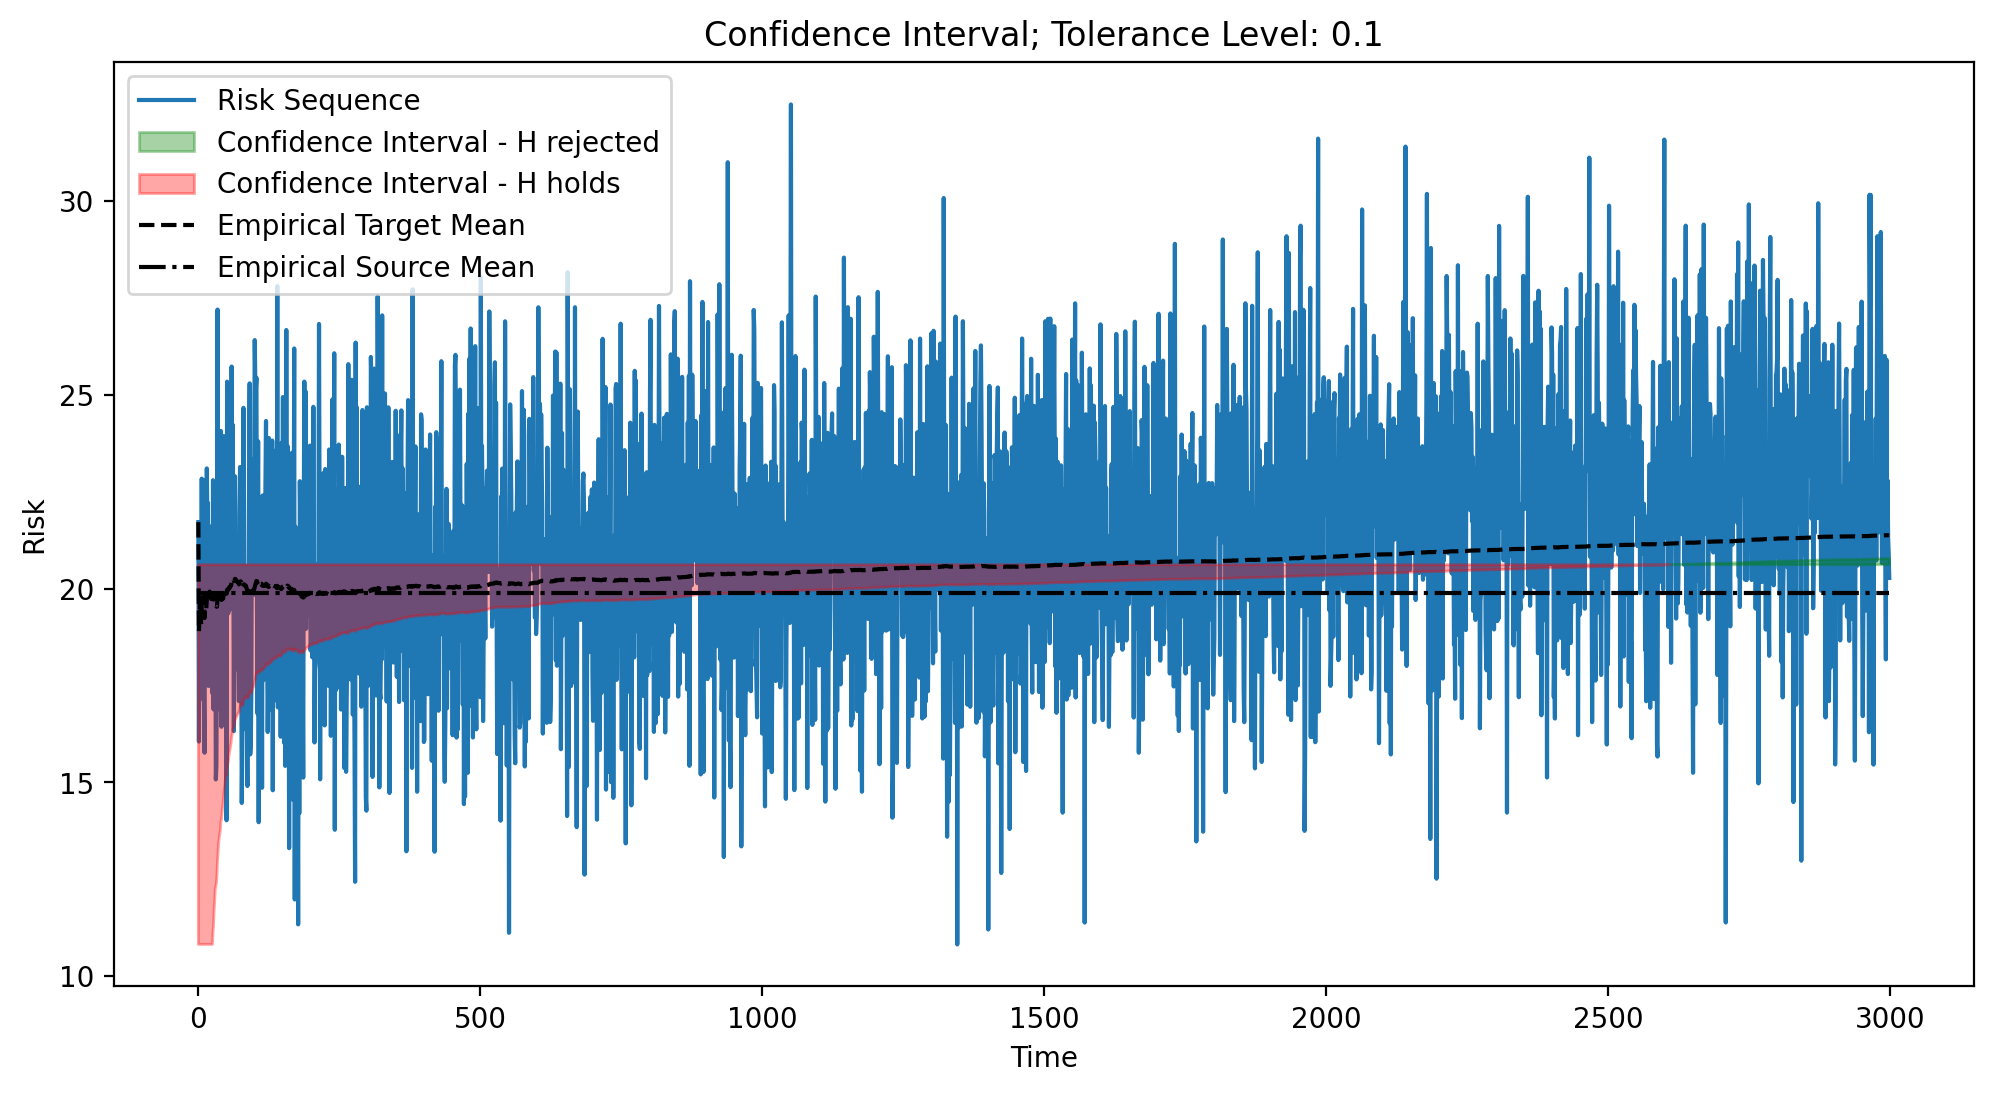

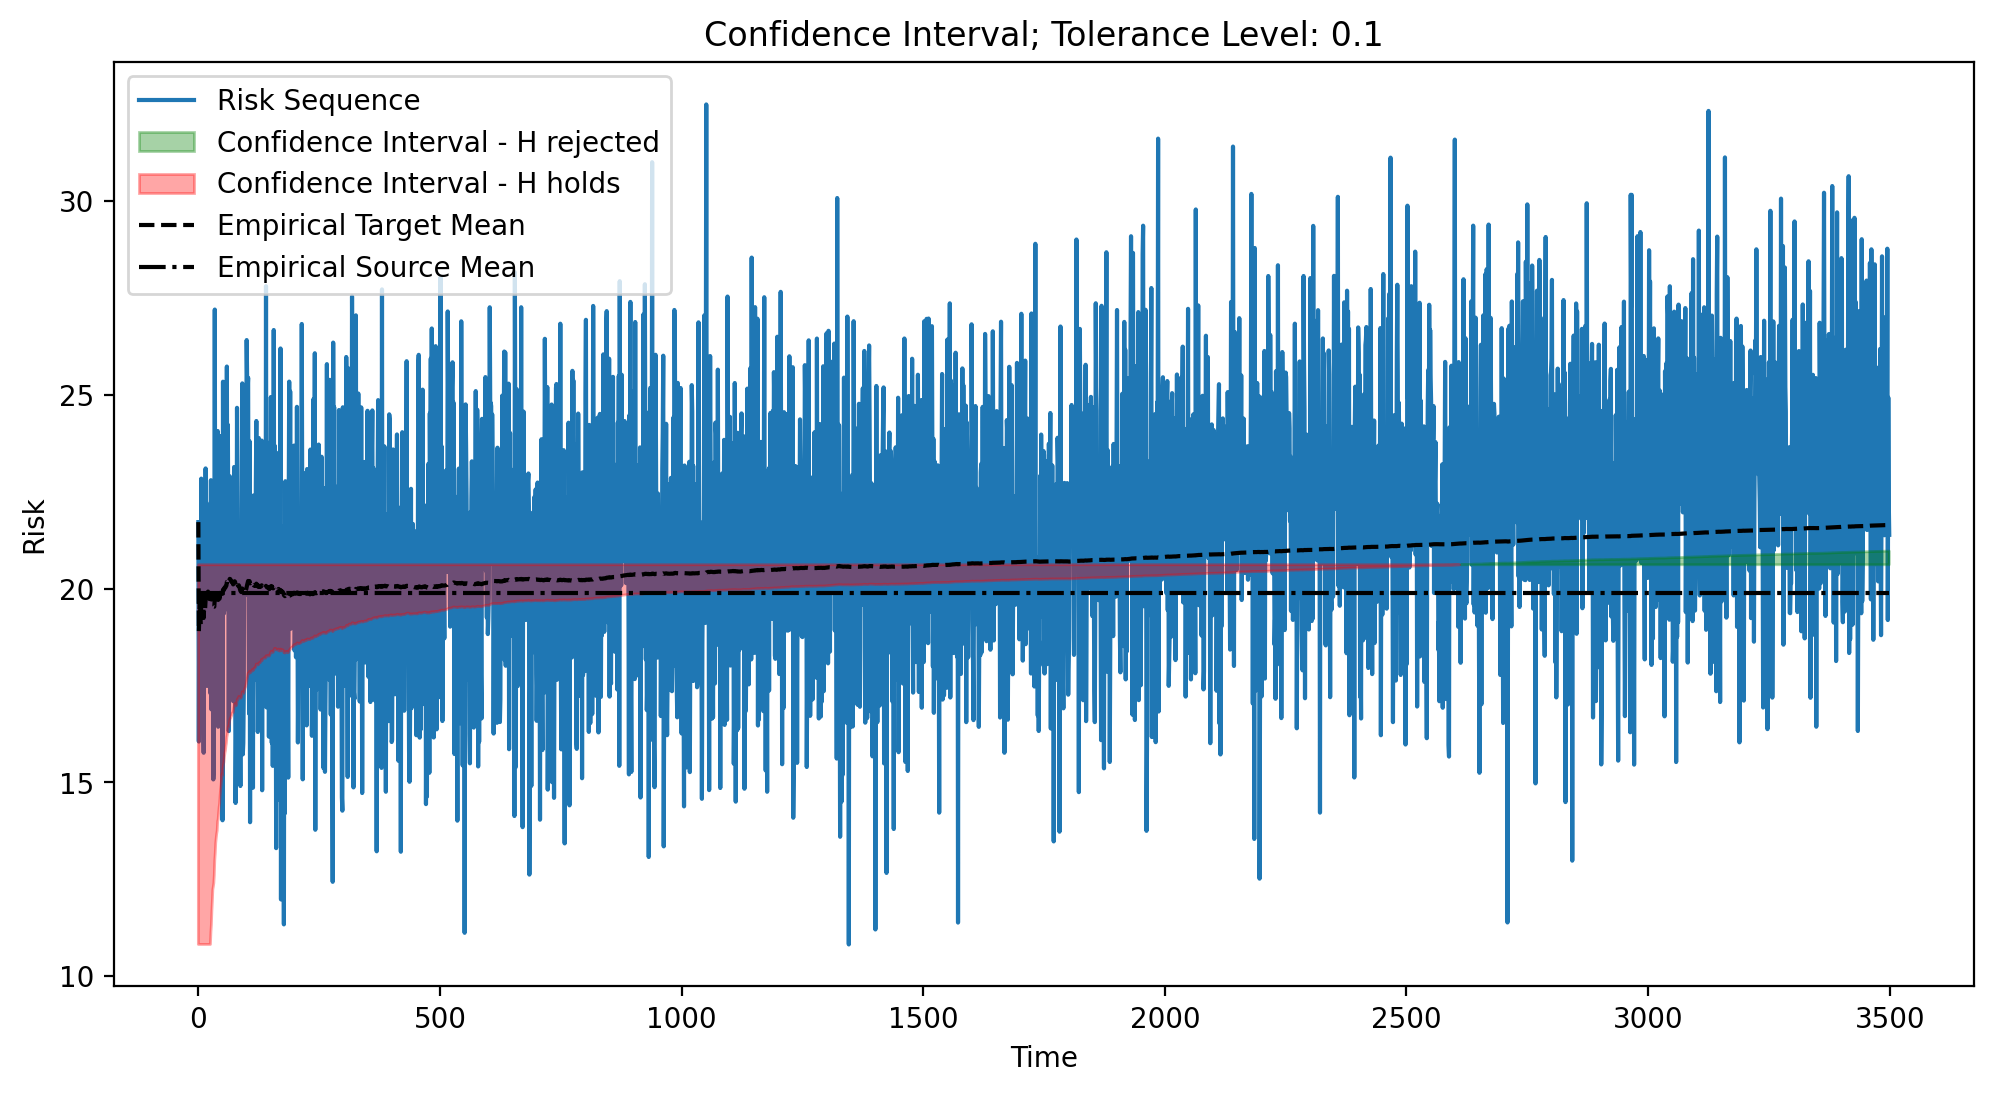

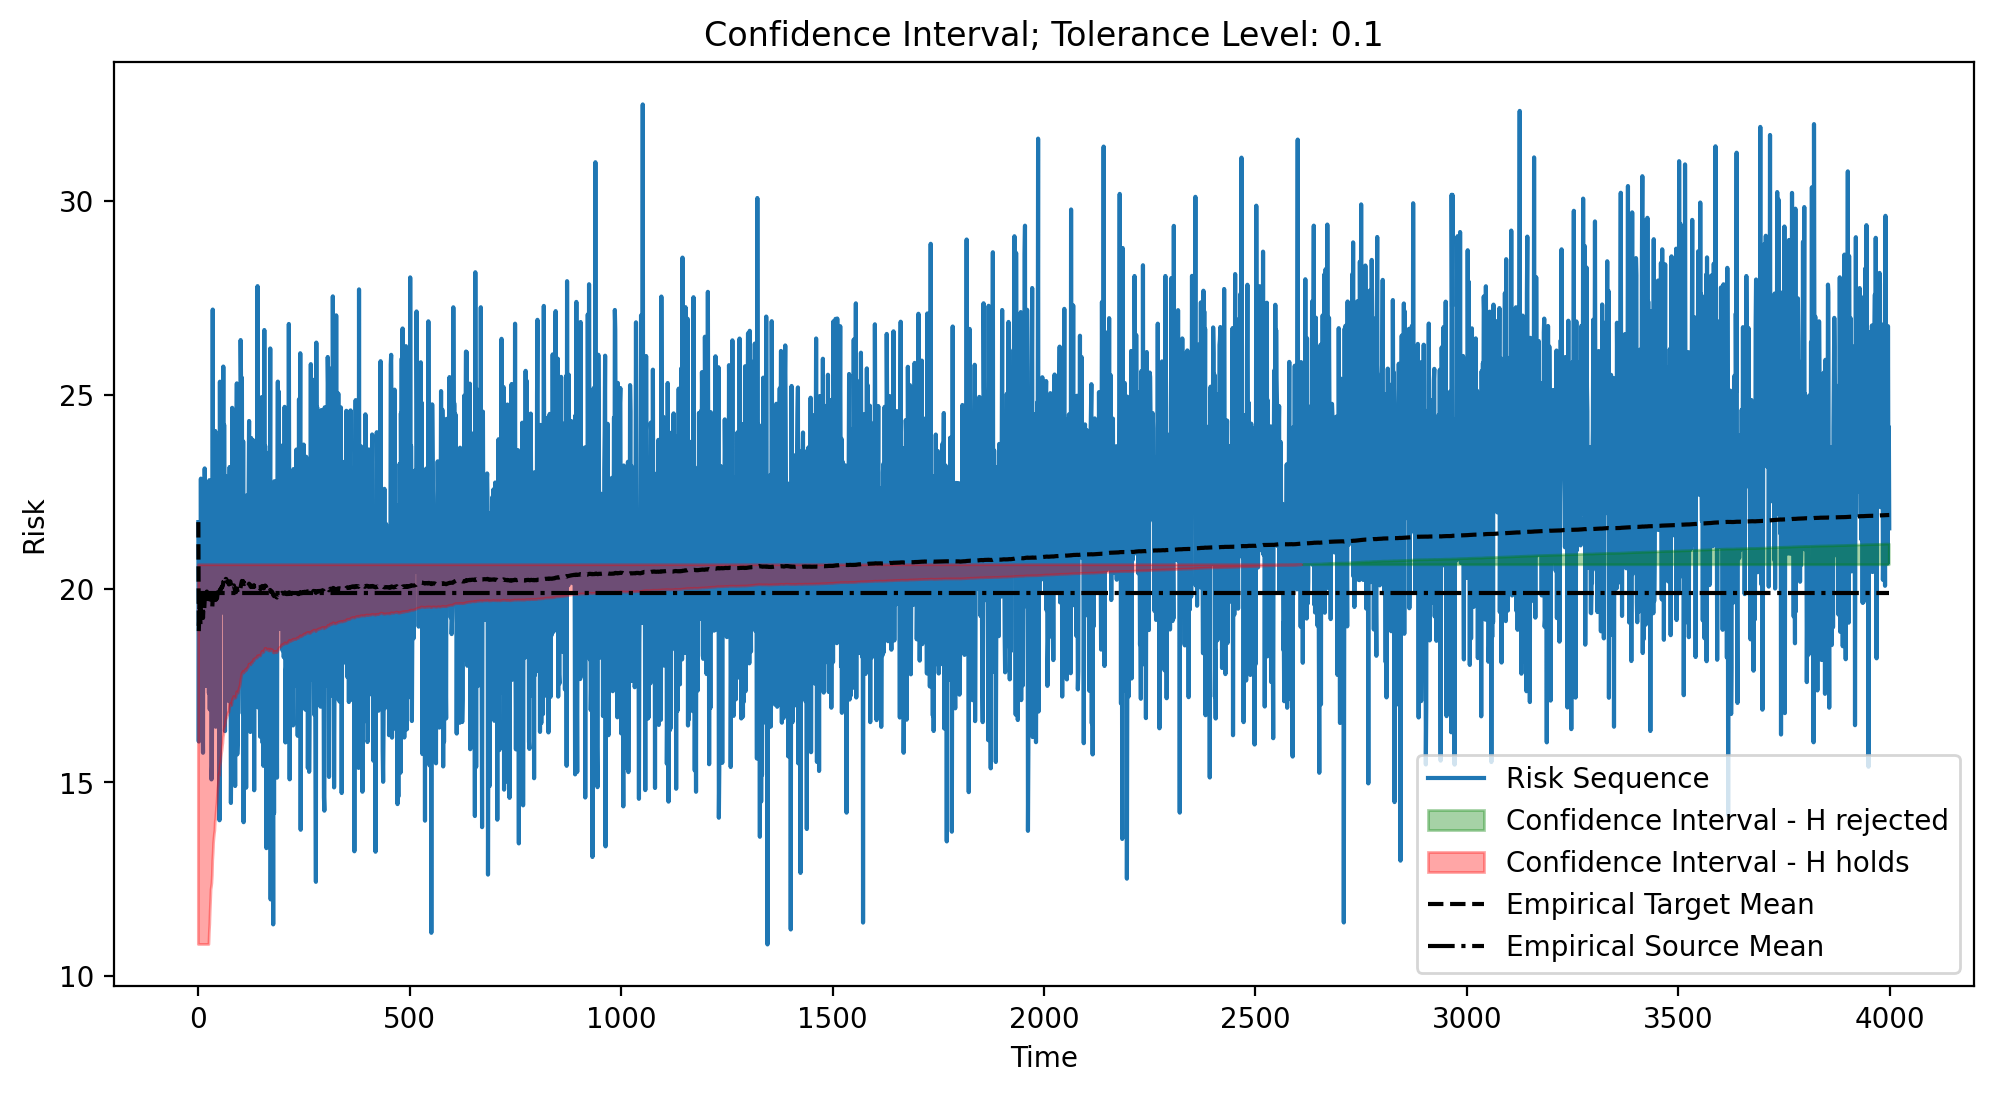

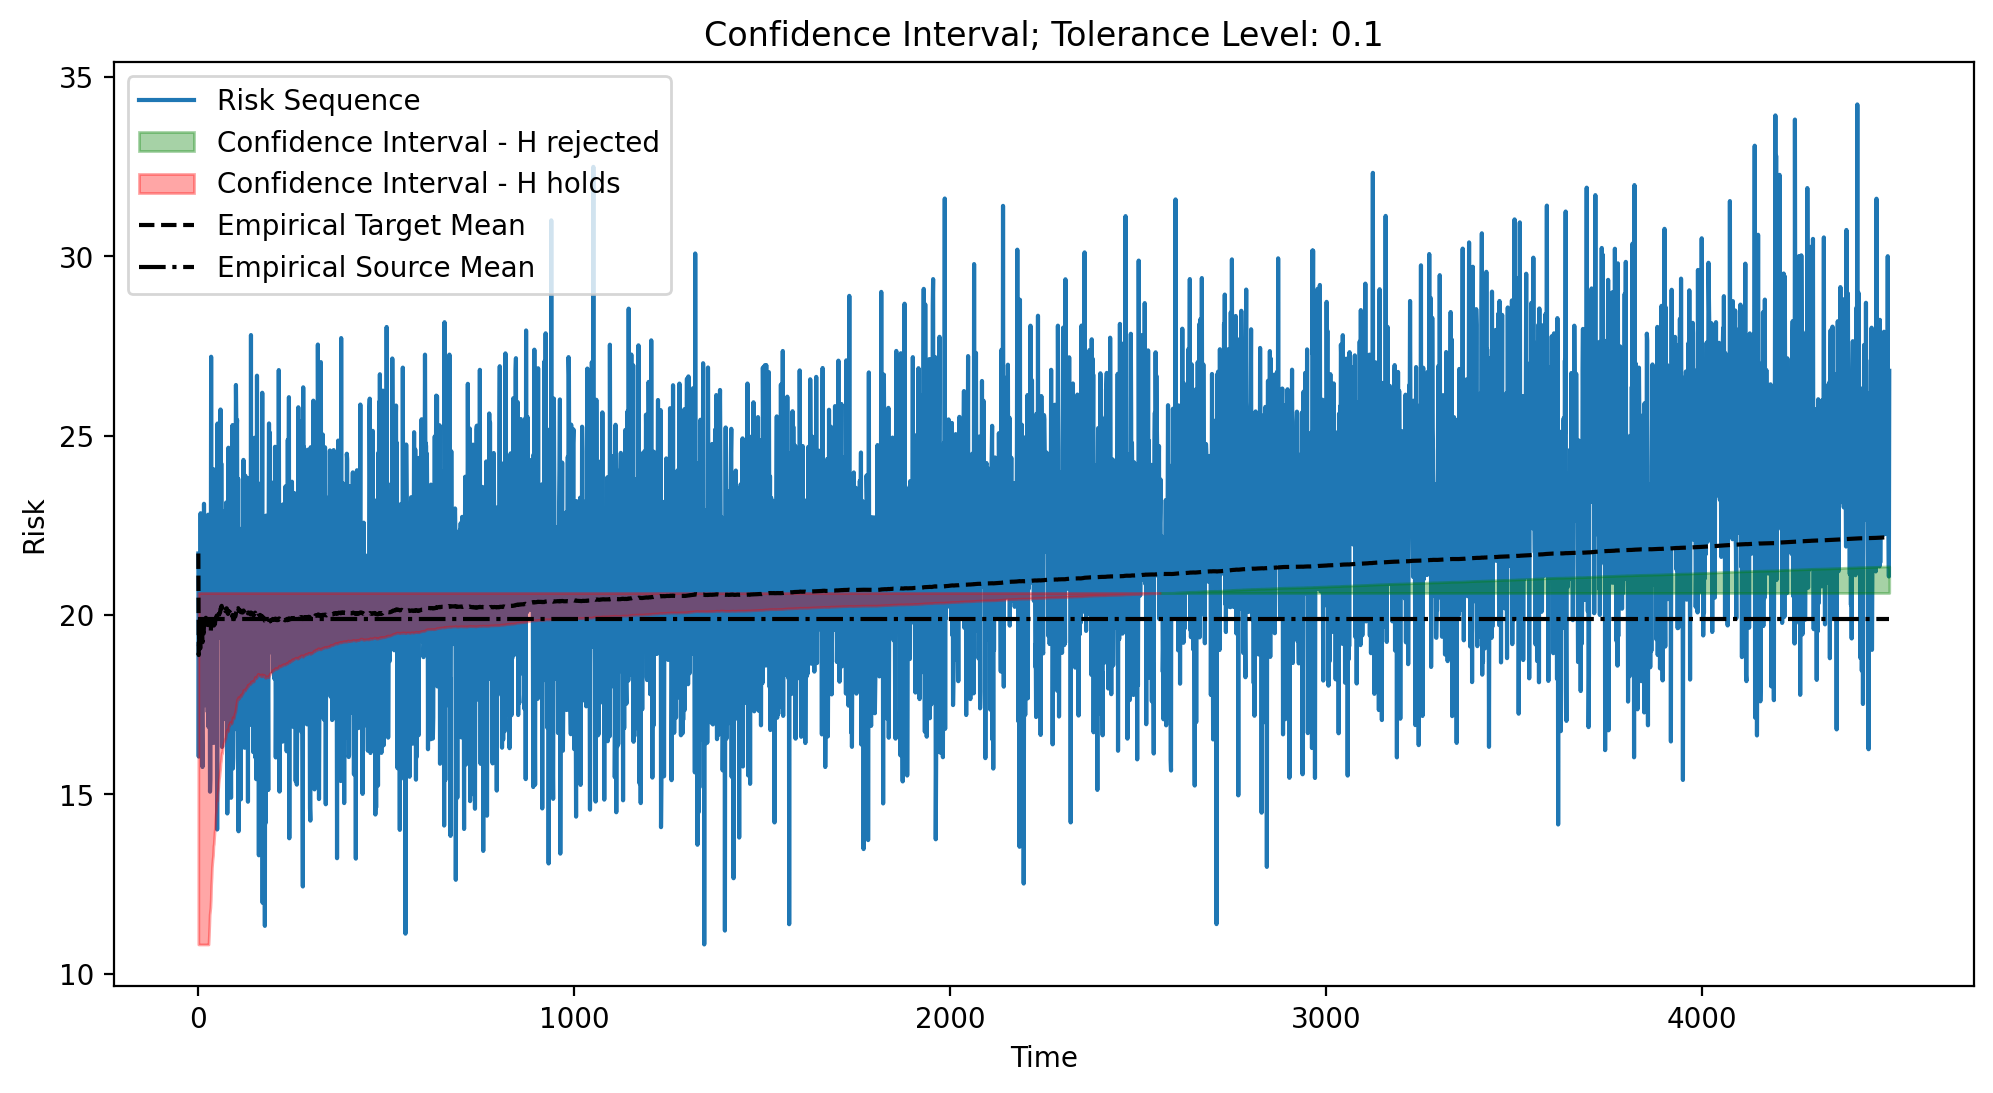

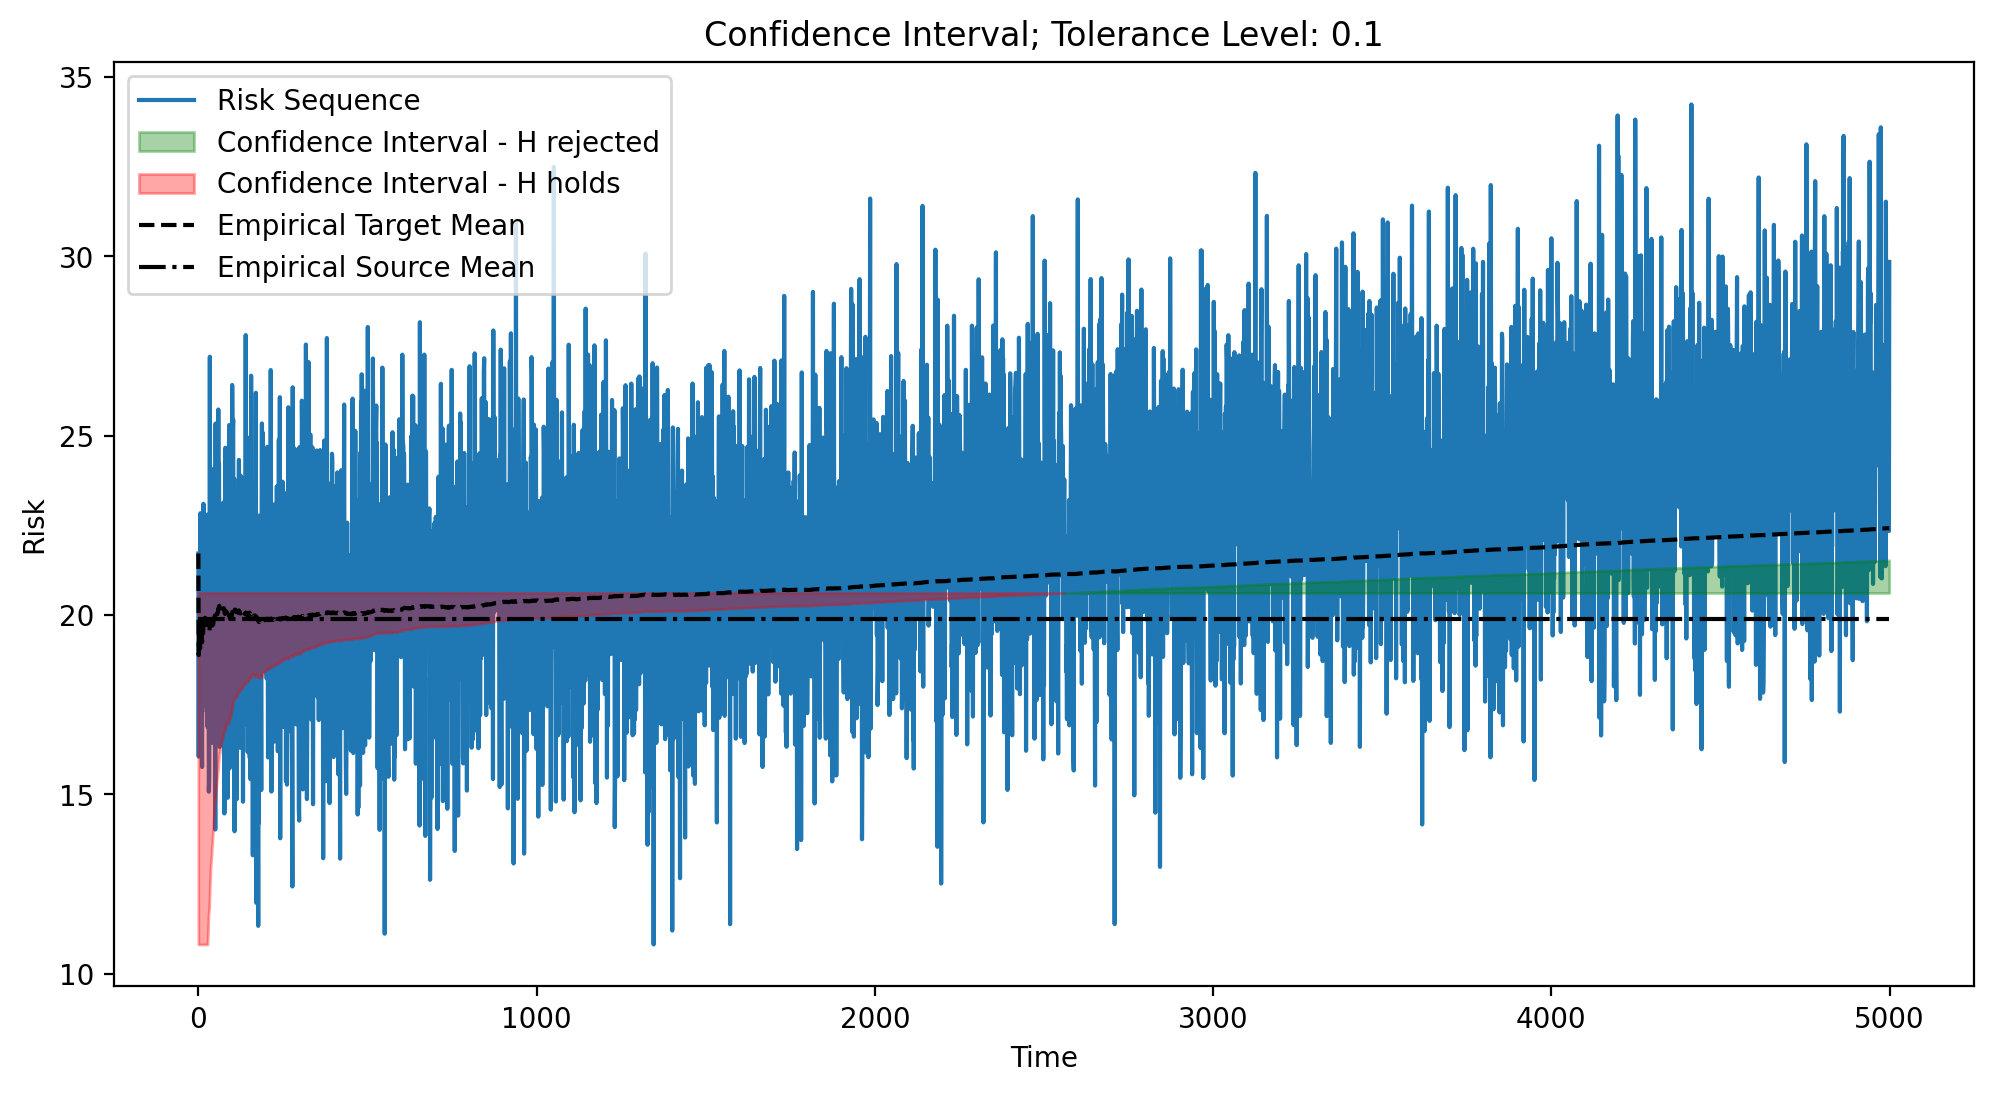

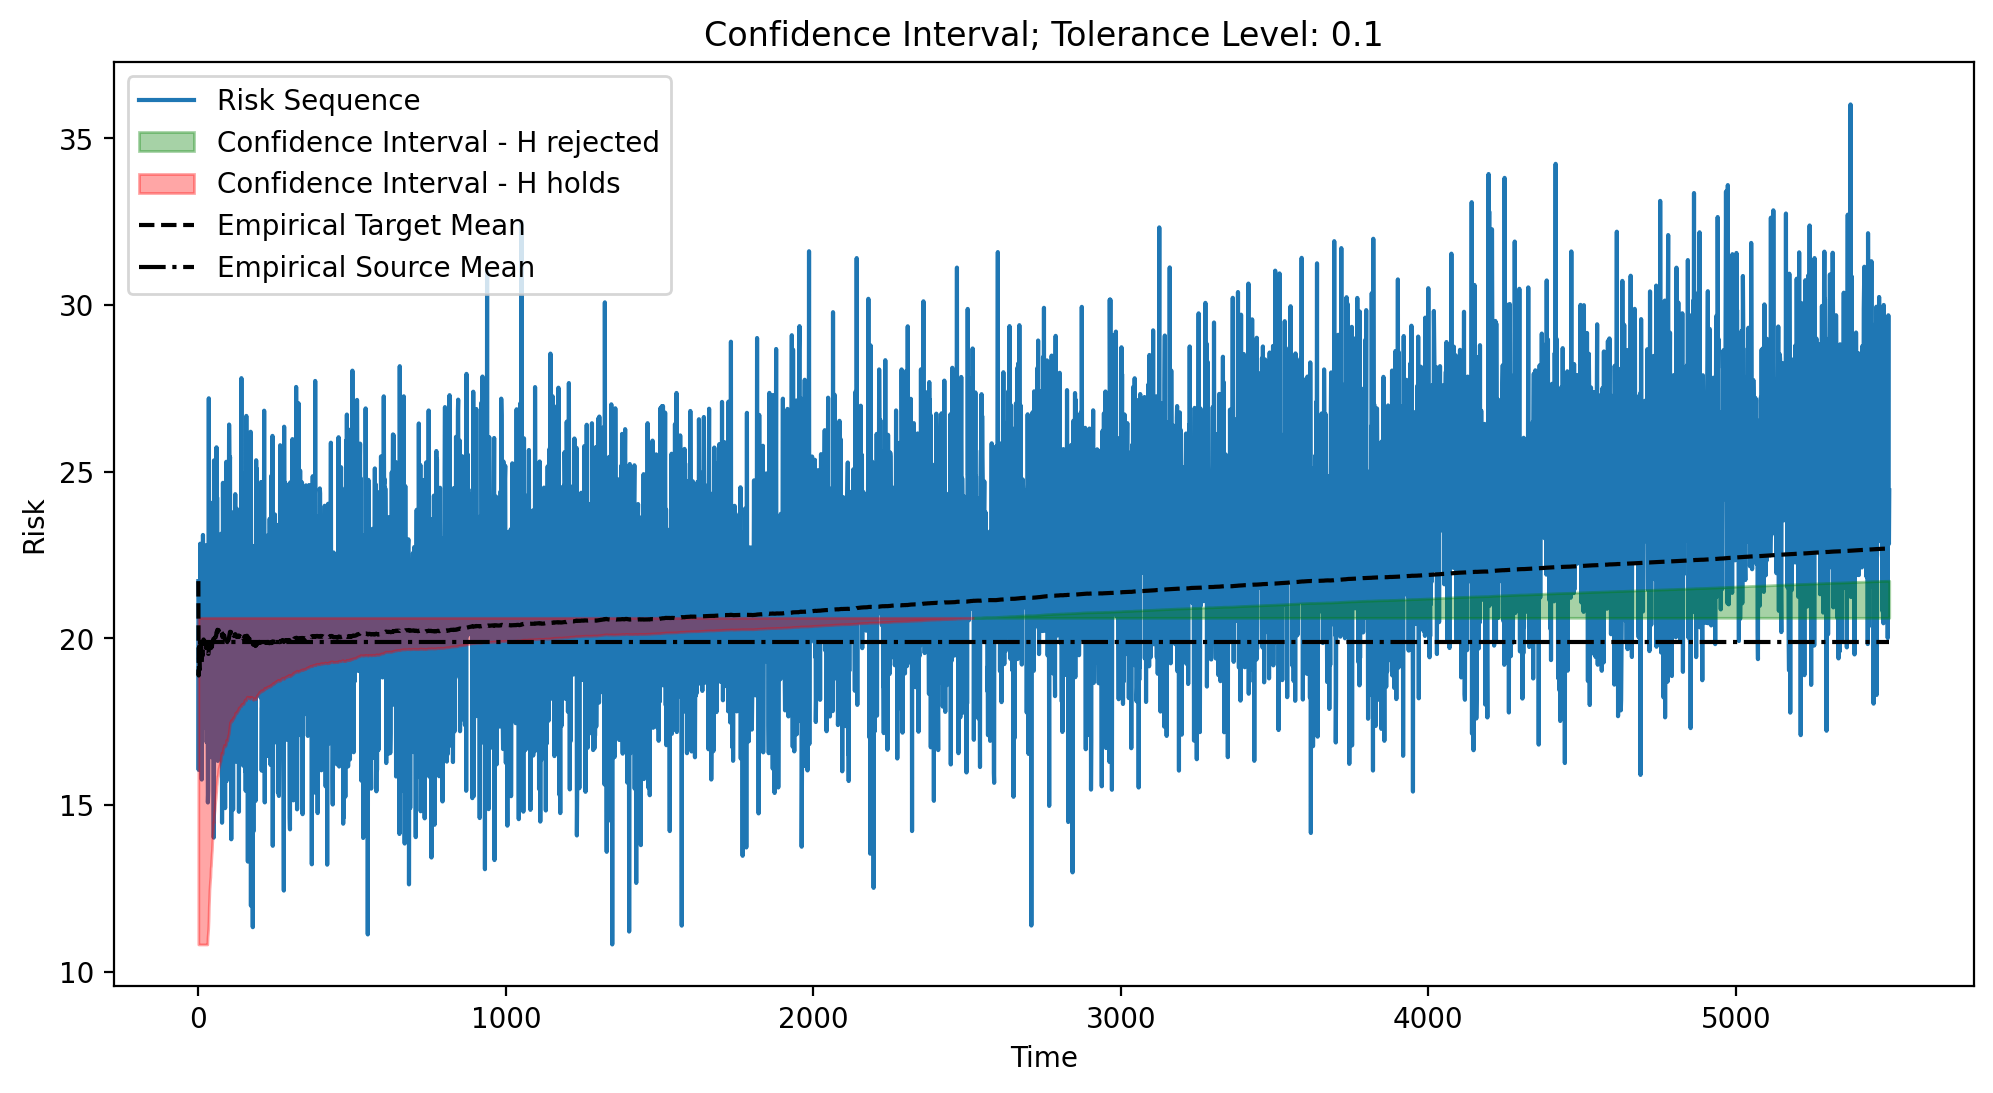

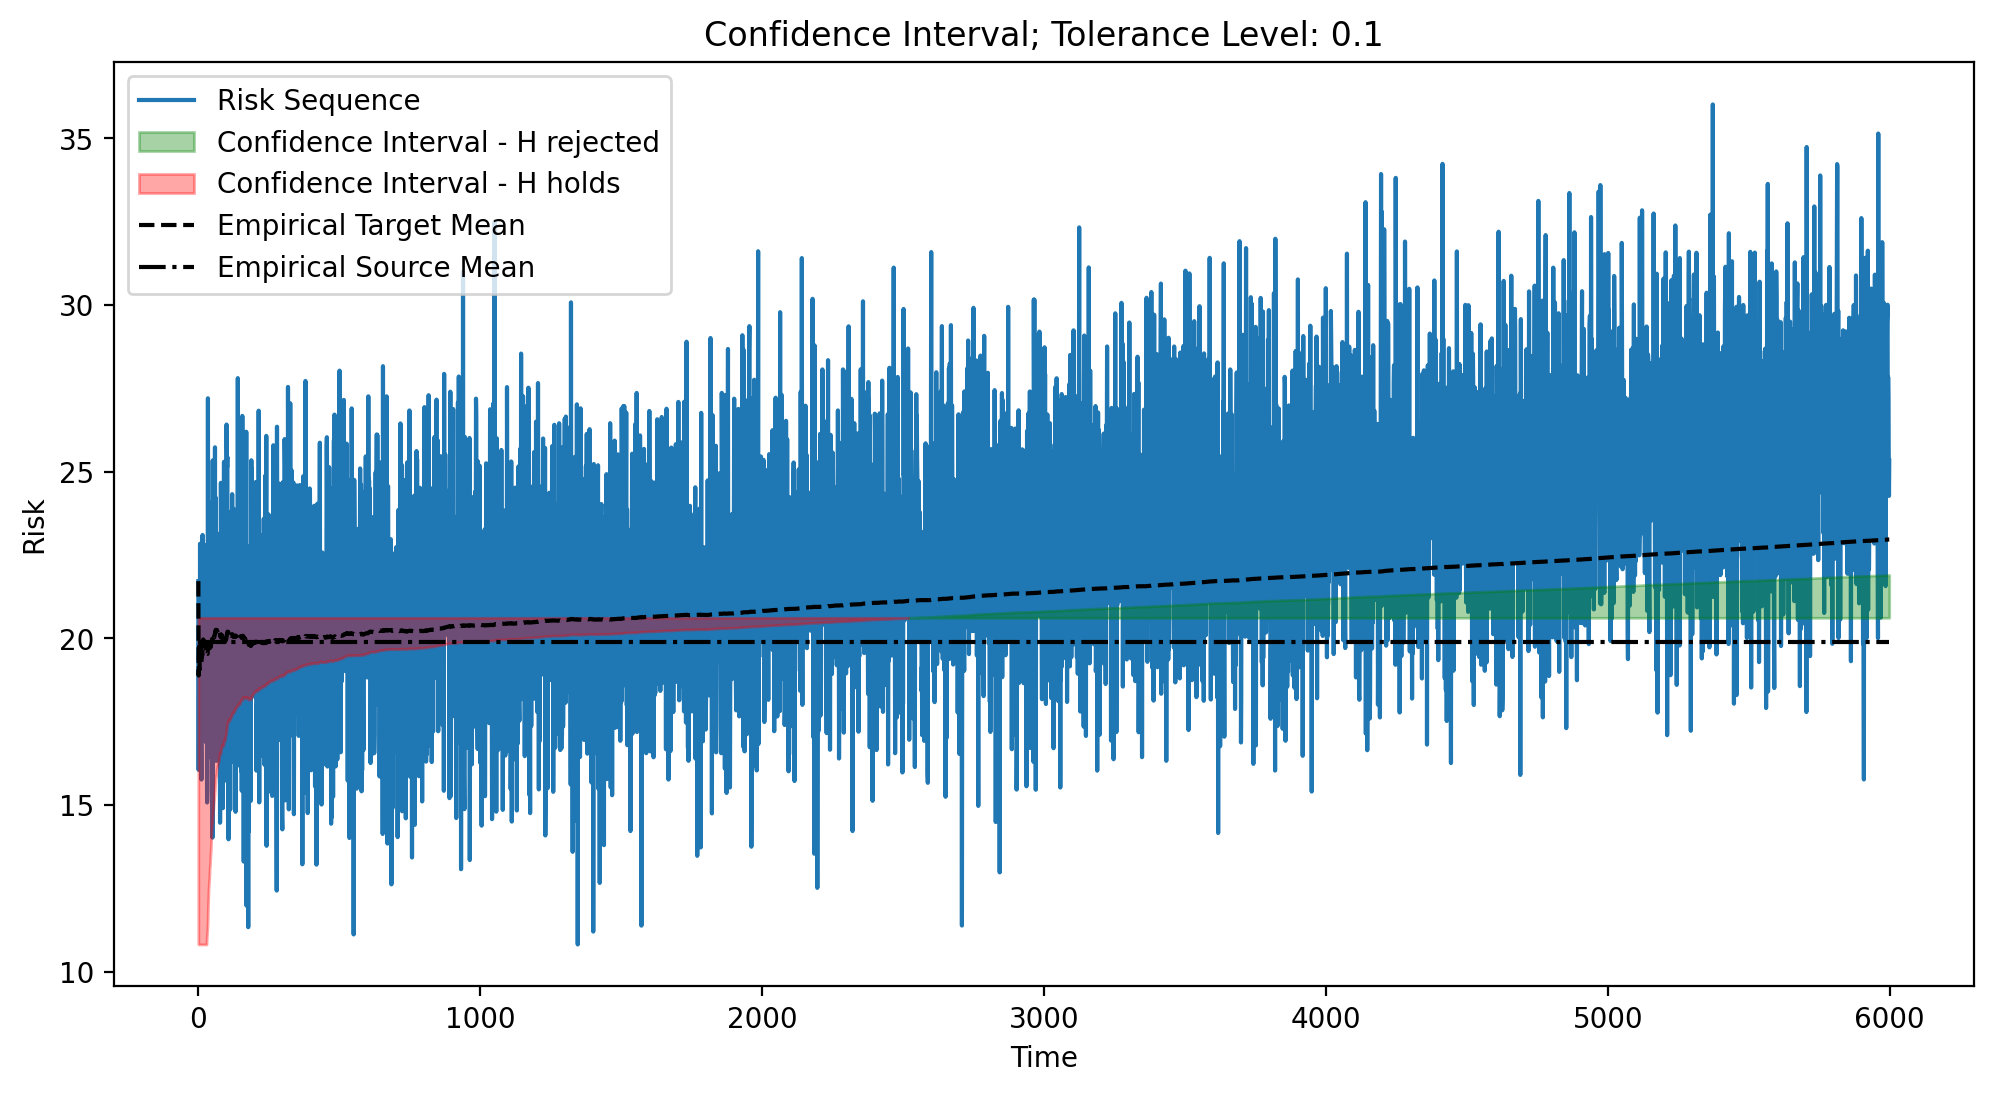

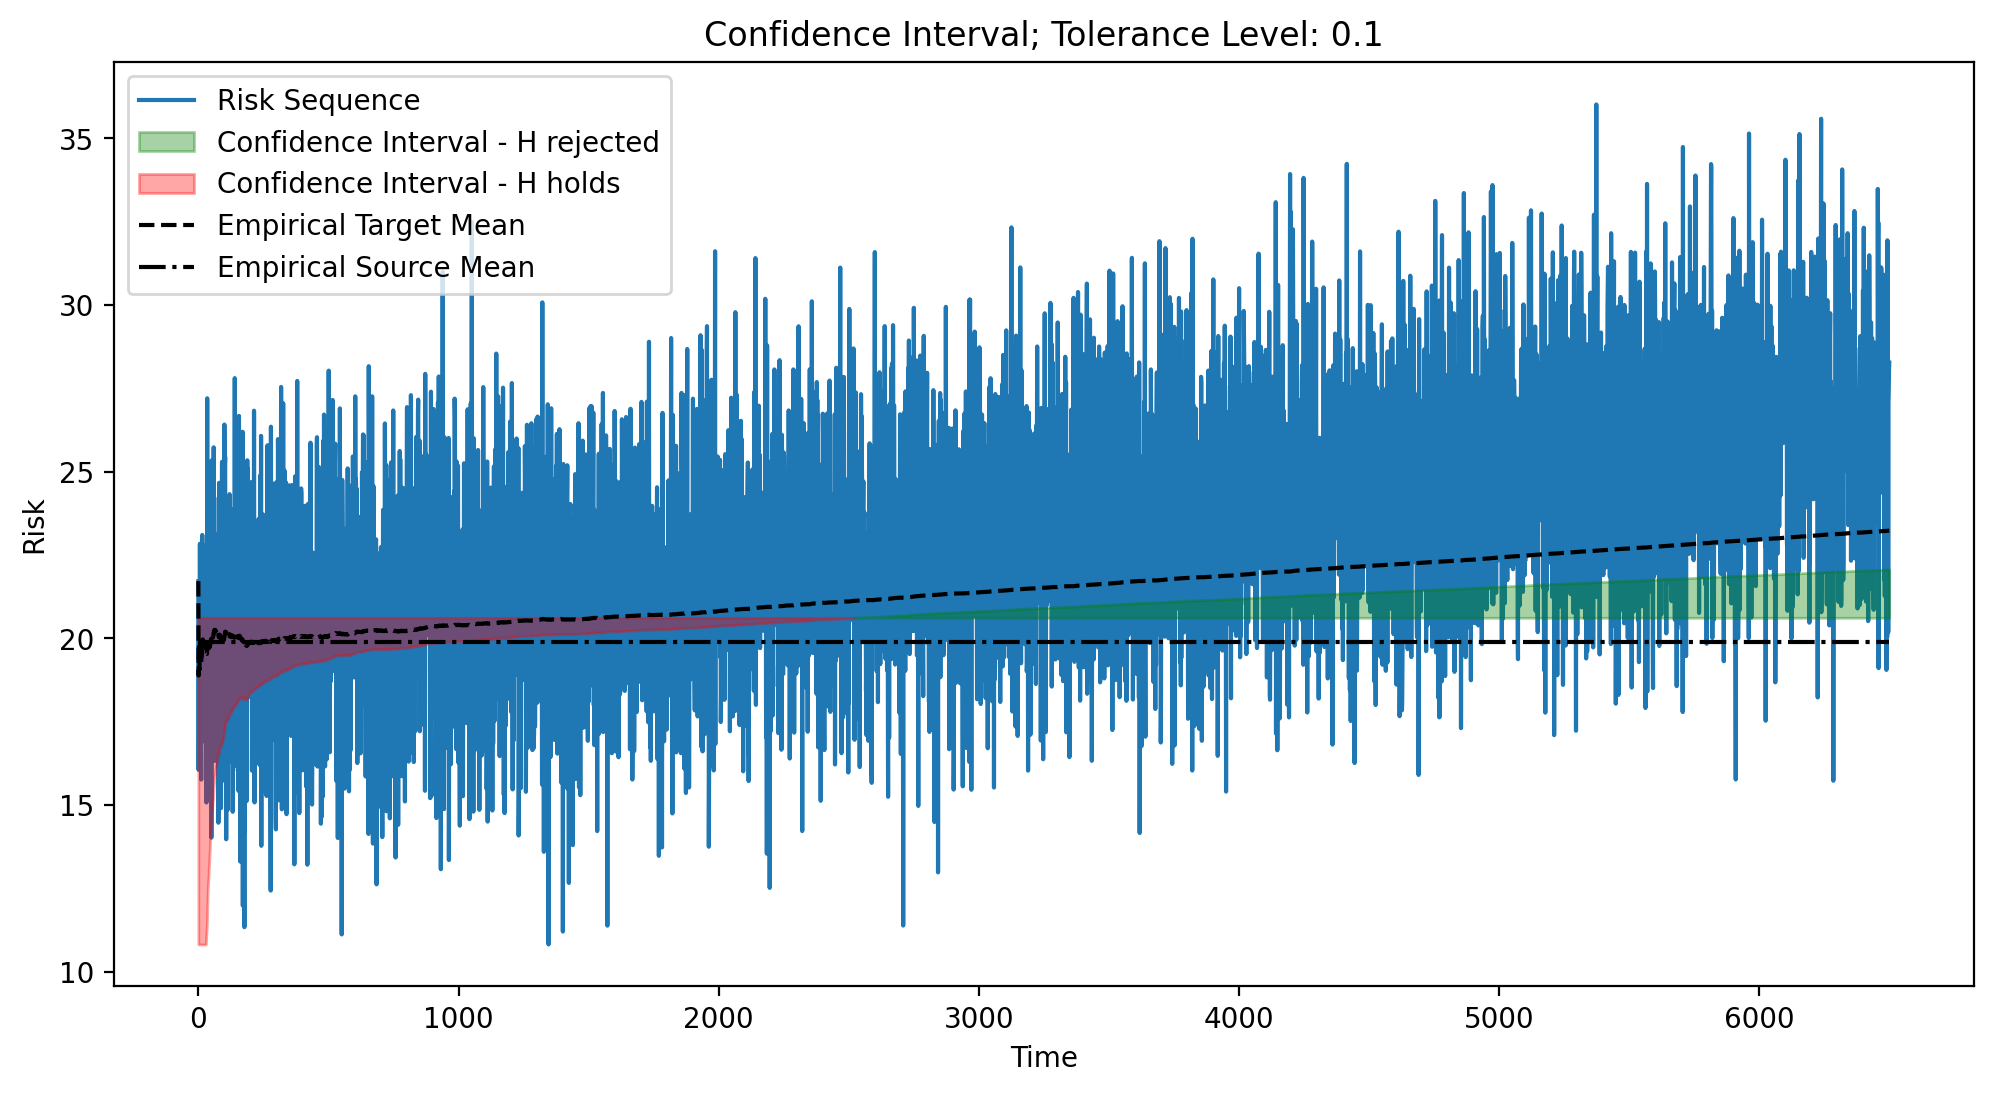

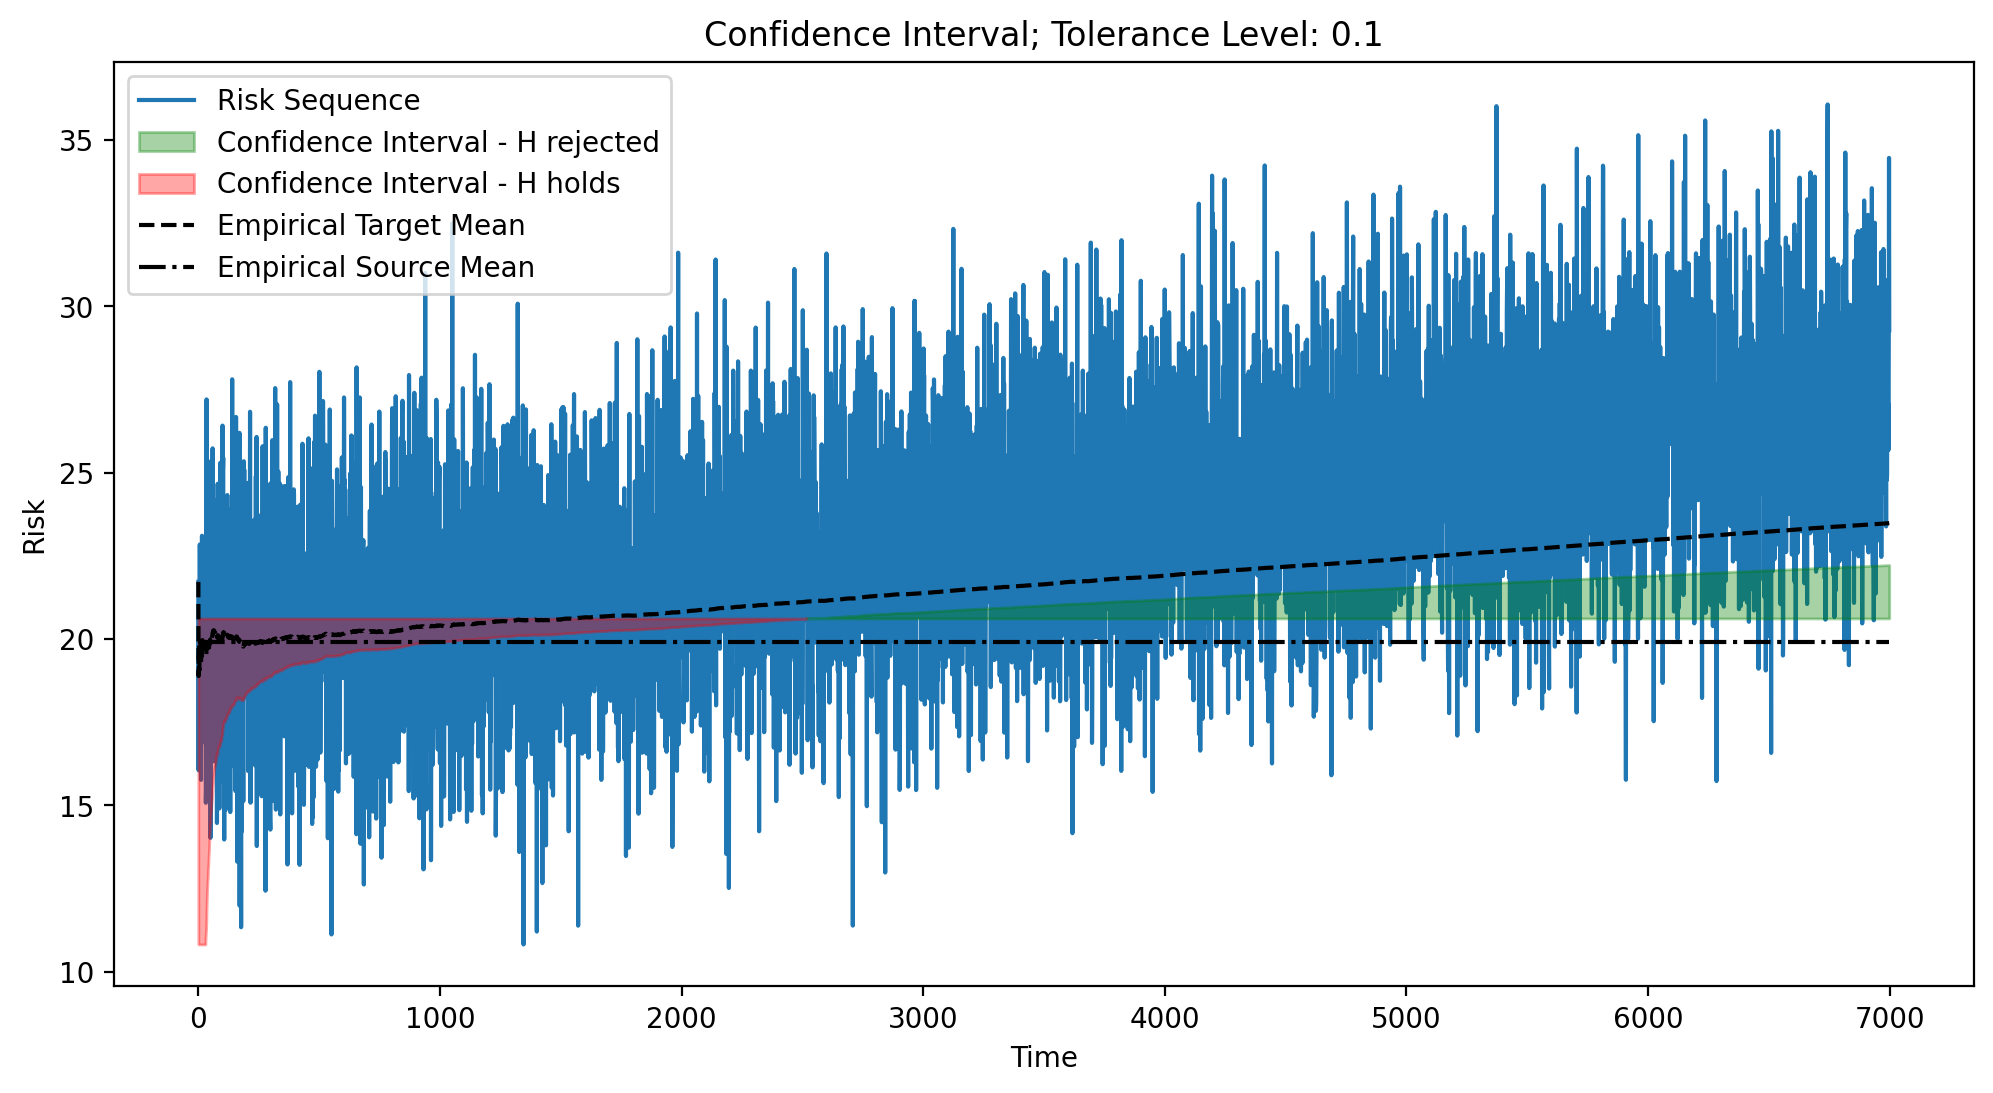

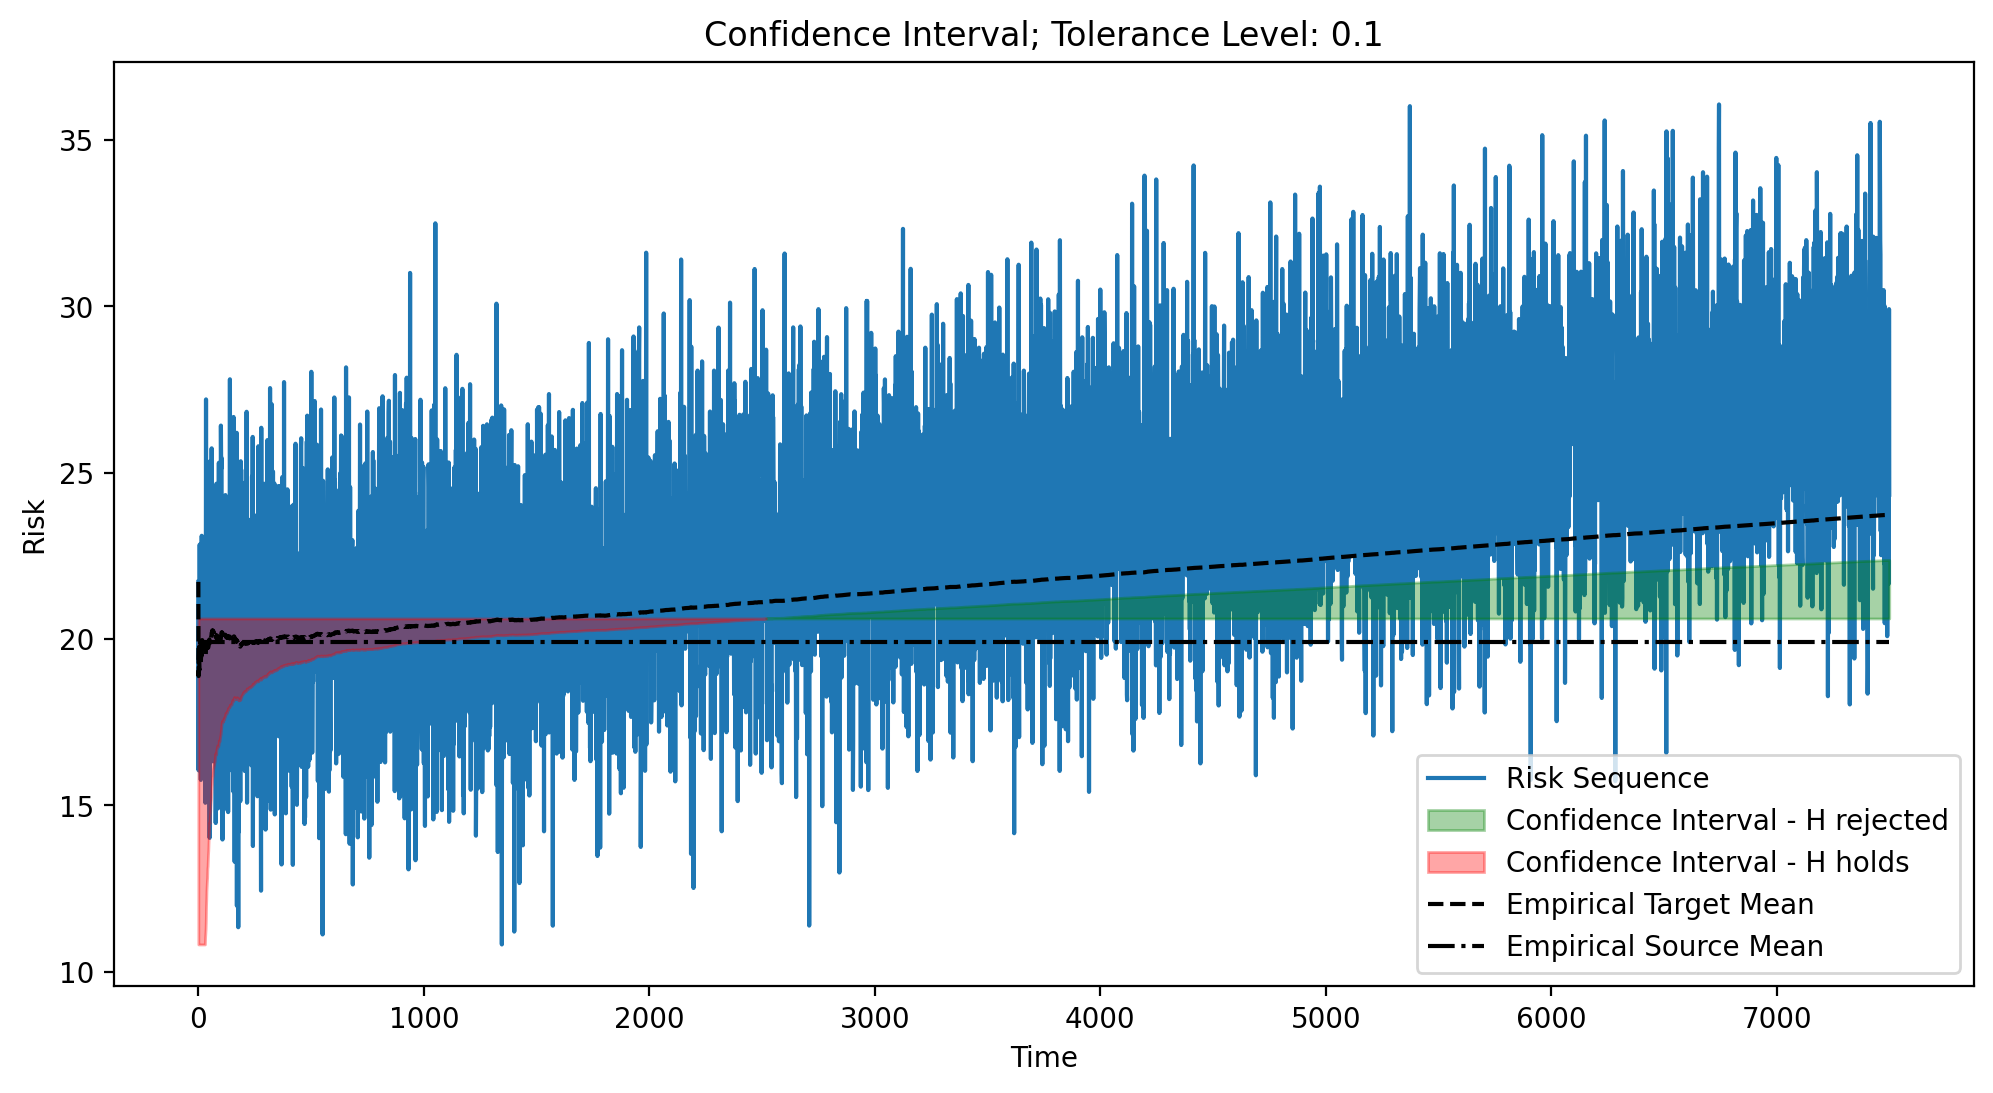

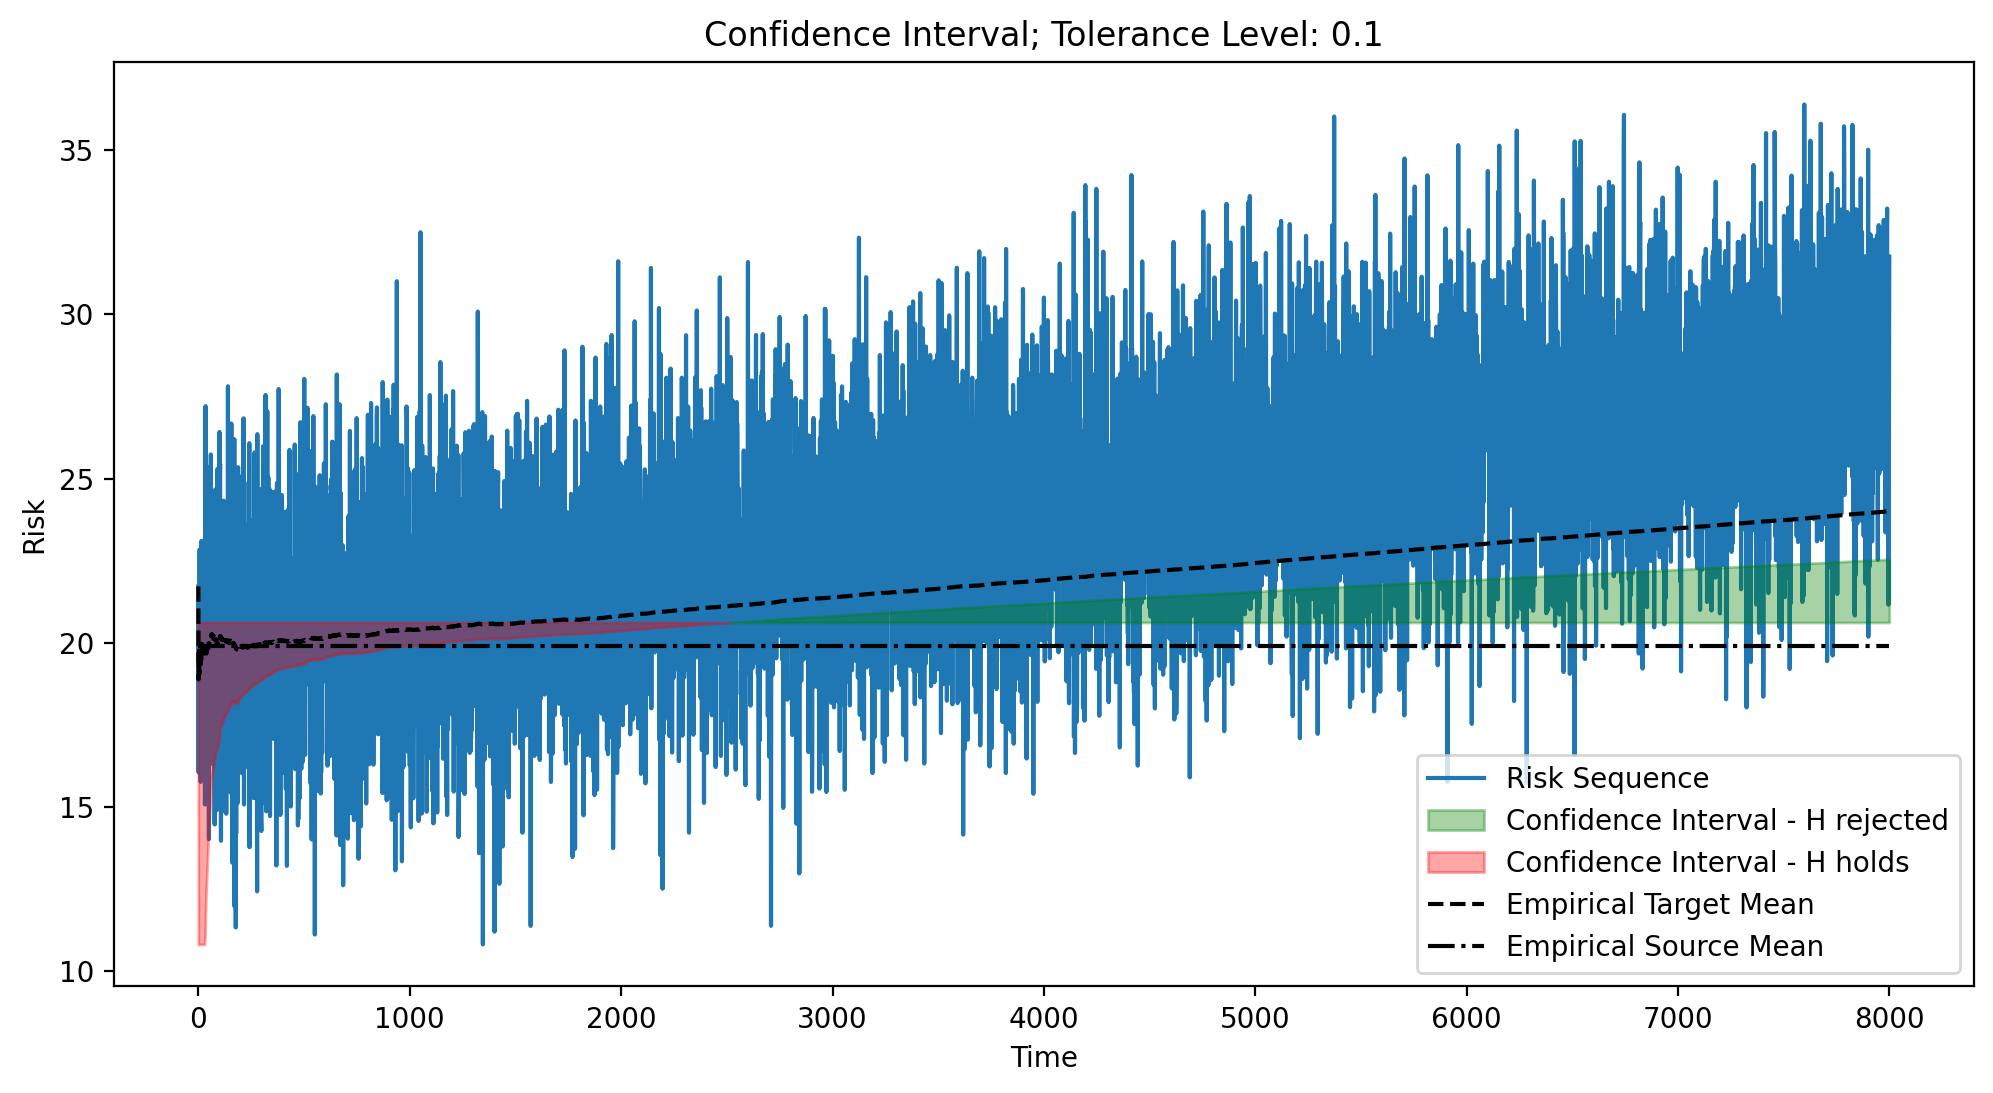

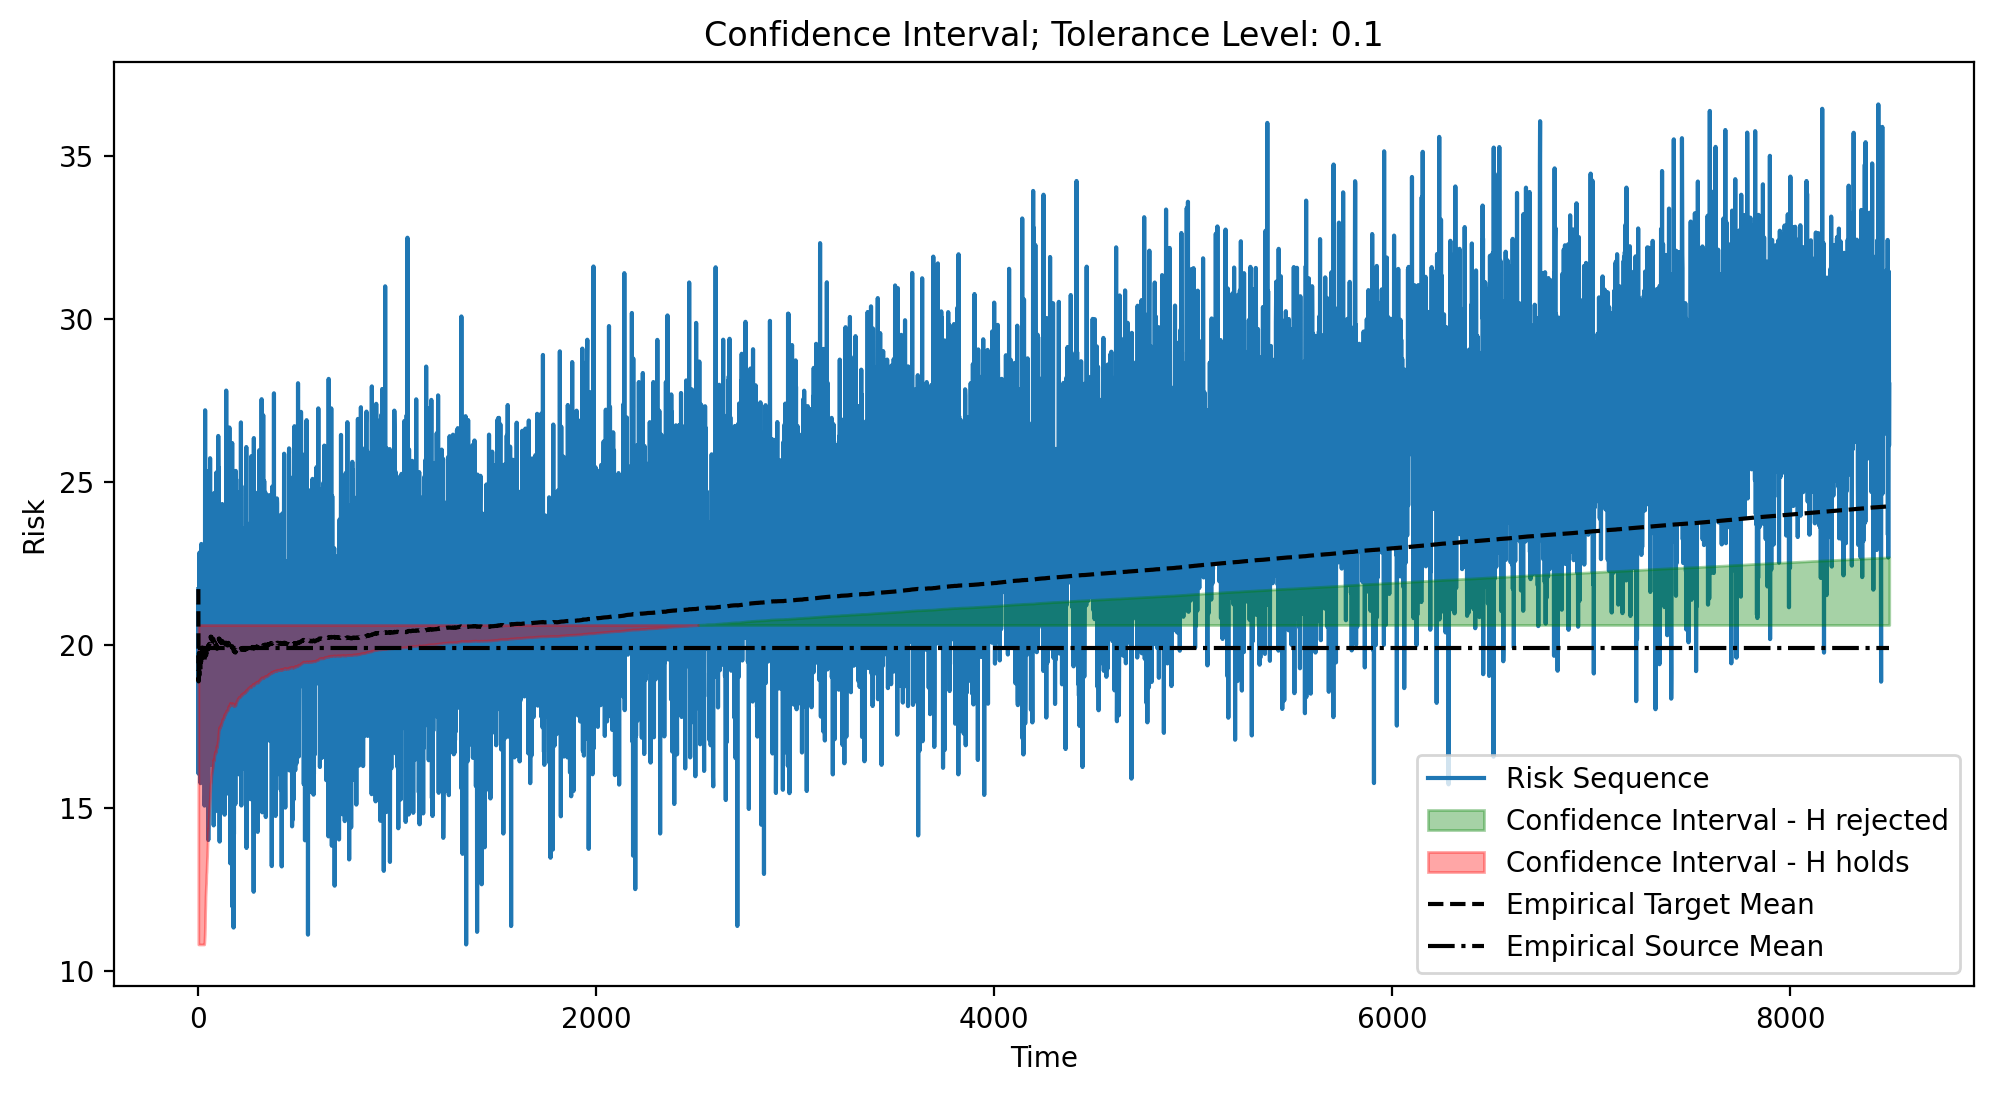

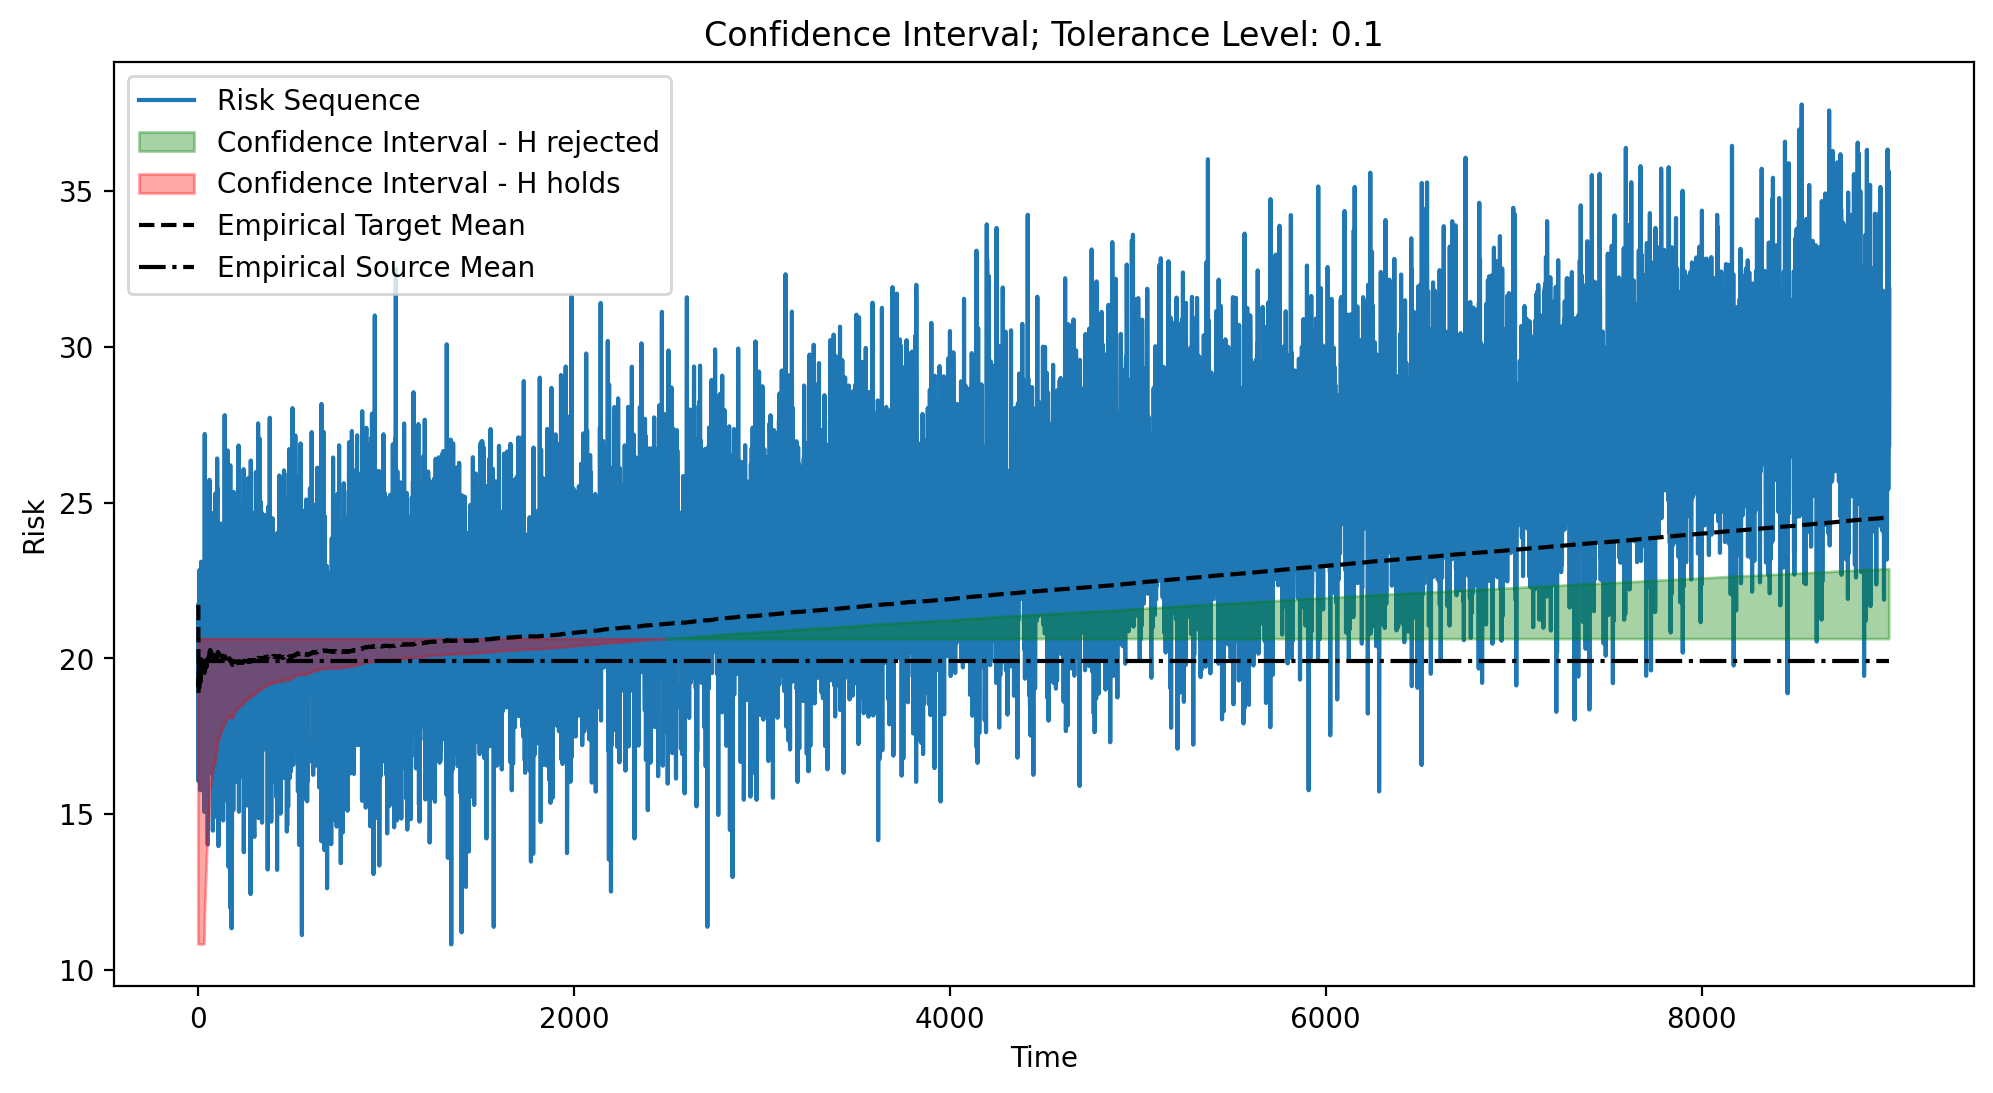

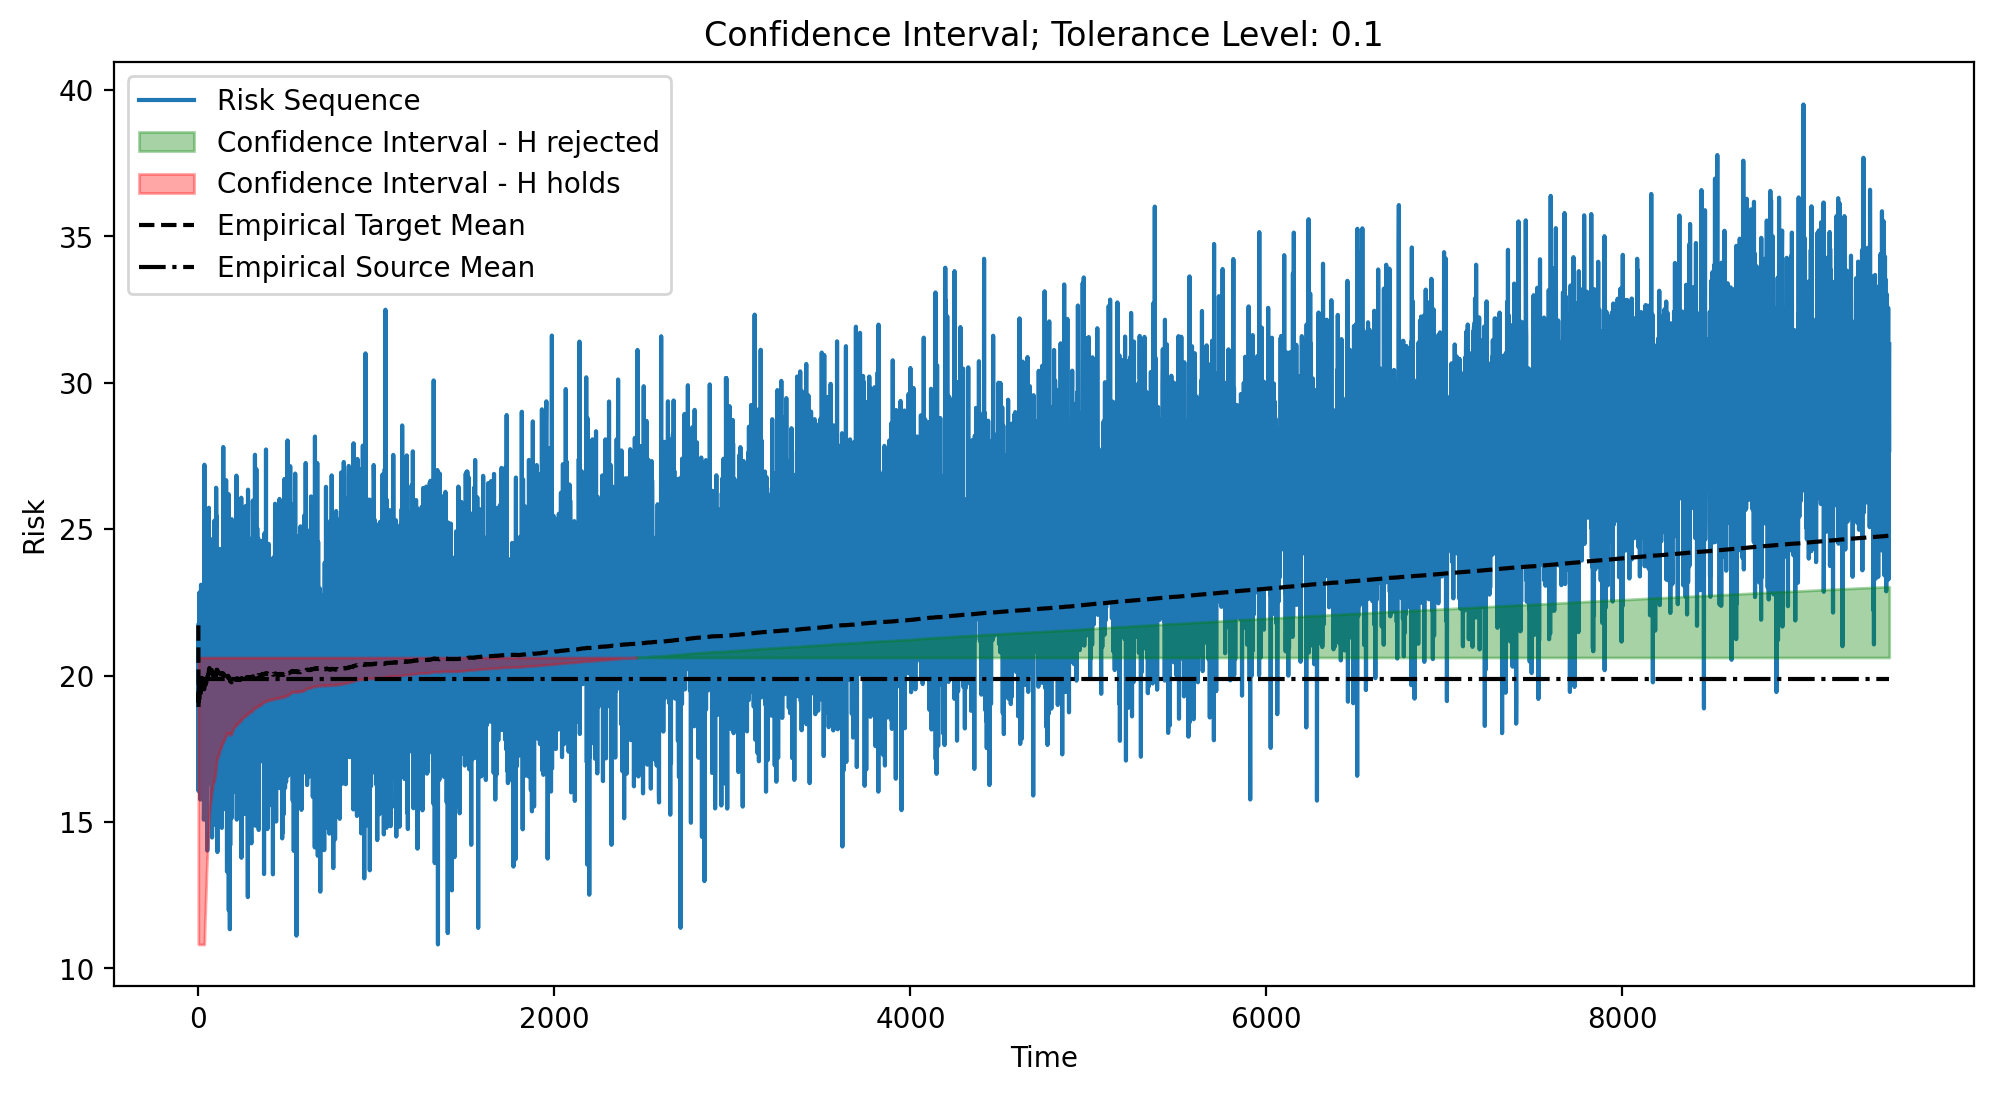

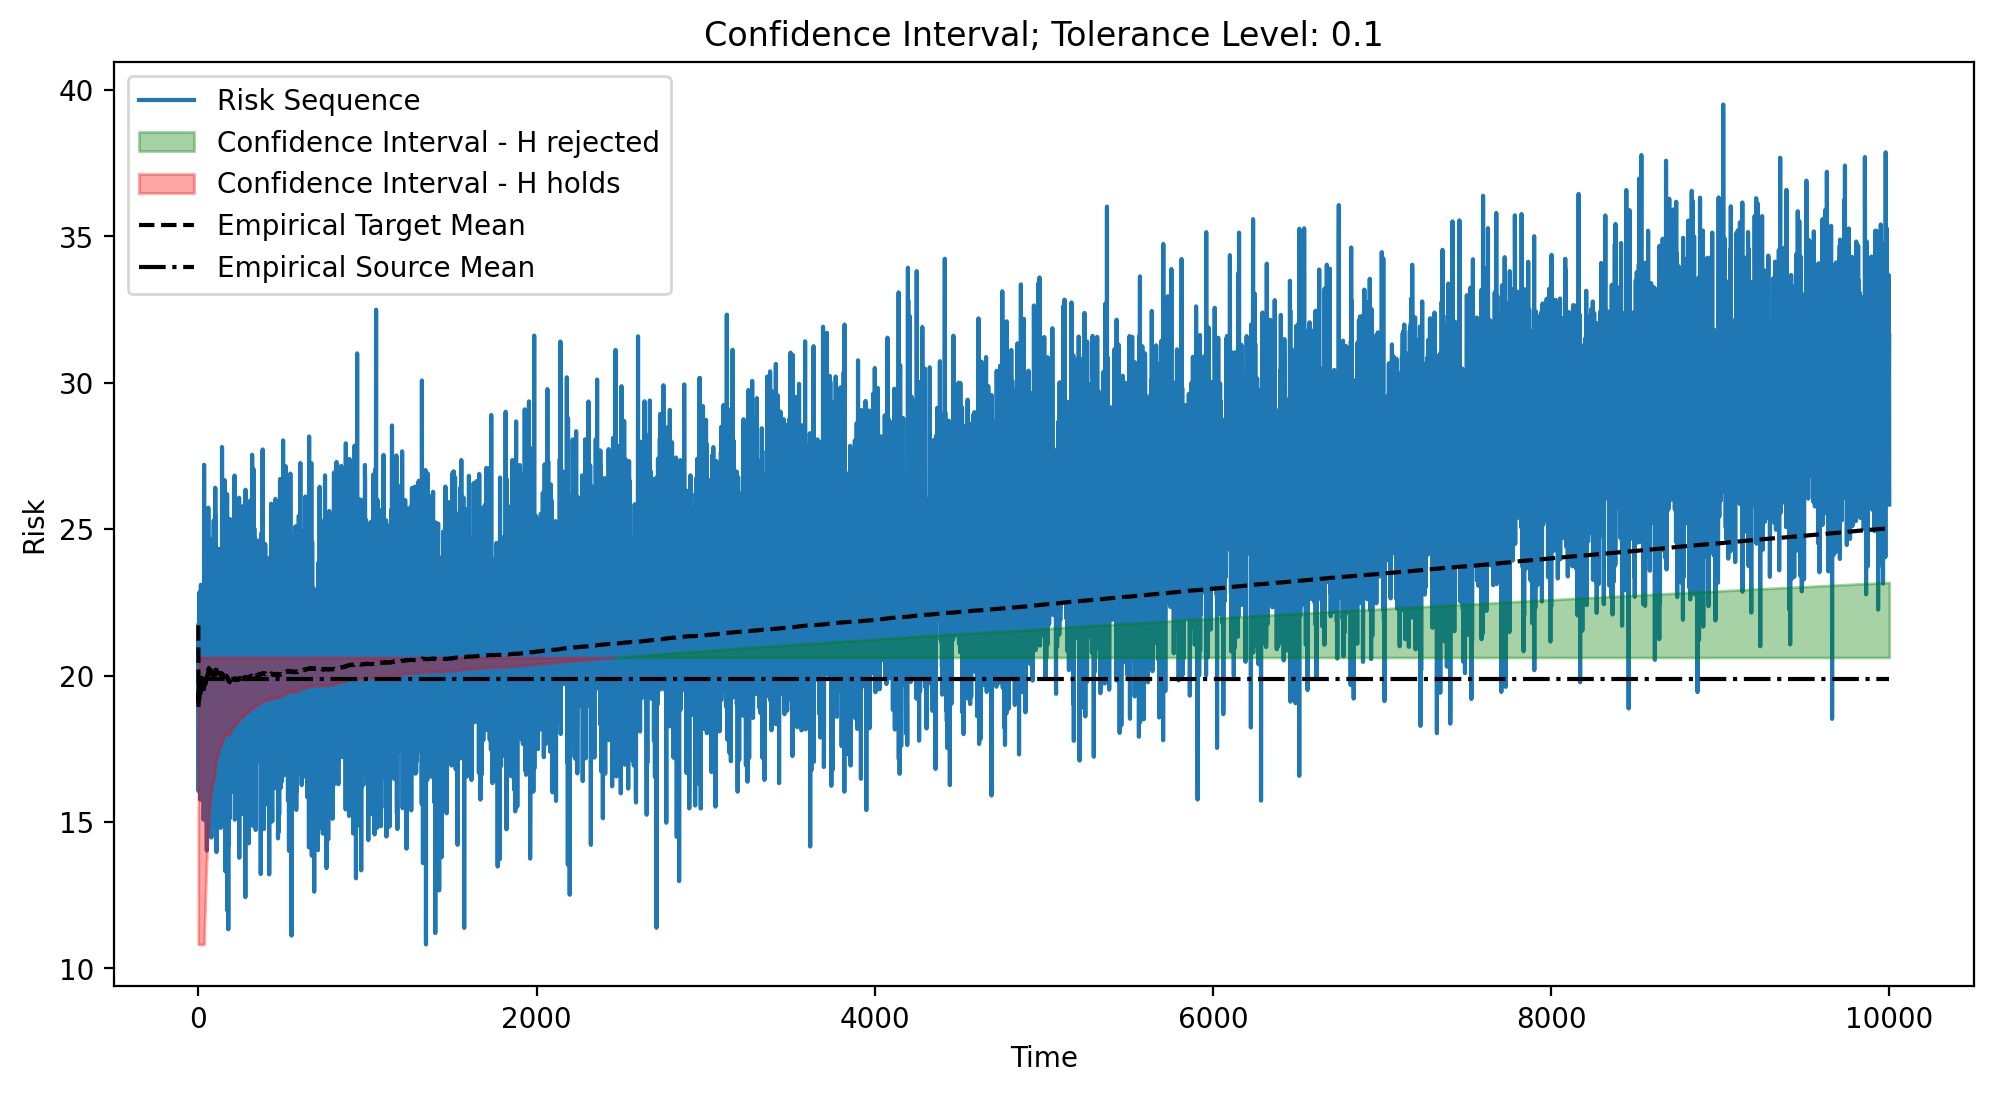

In [12]:
N_SOURCE = 1000
N_TARGET = 10000
# gamma = 0.95
source_mean = 20
source_var = 3
end_mean = 30
batch_size = 500

source_dataset = np.random.normal(source_mean, source_var, N_SOURCE)
shifted_mean = np.linspace(source_mean, end_mean, N_TARGET // batch_size)
target_dataset = [np.random.normal(mean, source_var, batch_size) for mean in shifted_mean]
target_dataset = np.concatenate(target_dataset)


source_bound = EmpbernConf(0.01)
target_bound = EmpbernConjmix(0.01)

hyp = H0(tolerance=0.1, lower_bound=source_bound, upper_bound=target_bound)
hyp.calc_source_upper_cs(source_dataset)

for i in range(0, N_TARGET, batch_size):
    data = target_dataset[i:i+batch_size]
    hyp.test(data)
    hyp.plot()



